# Portfolio Optimization Data Science Project

## Overview
This project aims to perform portfolio optimization using historical stock data. We will construct an optimal portfolio by selecting asset weights that maximize the Sharpe Ratio.

## Problem Formulation
The objective is to **maximize** the [Sharpe ratio](https://en.wikipedia.org/wiki/Sharpe_ratio), defined as:

$$
\text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}
$$

Where:
* $R_p$ is the expected portfolio return.
* $R_f$ is the risk-free rate.
* $\sigma_p$ is the portfolio standard deviation (volatility).

## Constraints
1.  **Fully Invested:** The sum of weights must equal 1 ($\sum w_i = 1$).
2.  **Long-Only:** Weights must be non-negative ($w_i \geq 0$).

### 1. Import Libraries
First, we need to import the necessary libraries for data manipulation (`pandas`, `numpy`), data fetching (`yfinance`), visualization (`matplotlib`,`seaborn`) and mathematical optimization (`scipy`).

In [ ]:
# Install yfinance if not present in the environment
# !pip install yfinance

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import datetime

# Set plotting style for better visuals
plt.style.use('ggplot')

Libraries have been successfully imported. We are now ready to define the functions required for our data pipeline. We will start with **Data Collection**.

### 2. Data Collection
We will define a function `collect_portfolio_data`  that accepts a list of stock tickers and a date range. It downloads historical data from Yahoo Finance and merges it into a single DataFrame.

In [ ]:
def collect_portfolio_data(portfolio_symbols, start_date, end_date):
    """
    Collect historical stock data for a portfolio of assets.
    """
    portfolio_data = pd.DataFrame()

    print(f"Fetching data for: {portfolio_symbols}...")

    for symbol in portfolio_symbols:
        try:
            # Fetch data using yfinance
            asset_data = yf.download(symbol, start=start_date, end=end_date, progress=False)

            # Handling different yfinance return formats (MultiIndex vs Single Level)
            if 'Adj Close' in asset_data.columns:
                if isinstance(asset_data.columns, pd.MultiIndex):
                    # If MultiIndex, extract the specific column
                    asset_data = asset_data.xs('Adj Close', level=0, axis=1)
                else:
                    asset_data = asset_data[['Adj Close']]
            else:
                # Fallback to Close if Adj Close is missing
                asset_data = asset_data[['Close']]

            # Rename column to the symbol for clarity
            asset_data.columns = [symbol]

            # Merge into the main dataframe
            if portfolio_data.empty:
                portfolio_data = asset_data
            else:
                portfolio_data = portfolio_data.join(asset_data, how='outer')

        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")

    return portfolio_data

The data collection logic is set. The raw data will contain prices, but for analysis, we need returns. Next, we define the **Data Preprocessing** logic.

### 3. Data Preprocessing
We define `preprocess_portfolio_data`. This function cleans the data by removing missing values and calculates:
1.  **Daily Returns:** Percentage change from the previous day.
2.  **Log Returns:** Logarithmic change, often used in financial modeling.
3.  **Rolling Metrics:** Moving averages and standard deviations (volatility).

In [ ]:
def preprocess_portfolio_data(data):
    """
    Preprocess historical stock data for a portfolio of assets.
    """
    data = data.copy()

    # Remove rows with missing values
    data.dropna(inplace=True)

    # Identify price columns (assuming numeric columns are tickers)
    price_cols = data.select_dtypes(include=[np.number]).columns

    # Calculate daily returns
    returns_df = data[price_cols].pct_change().dropna()

    # Add prefix to distinguish return columns if merging back (optional, here we return returns_df)
    # For this workflow, we will focus on the returns DataFrame for optimization

    return returns_df

With the preprocessing function ready, we can transform raw prices into returns. Now, we need a way to measure performance. We will define the **Portfolio Analysis** logic.

### 4. Analysis & Optimization logic
To do a comprehensive portfolio analysis and optimizing them we construct below two functions:

* **`calculate_portfolio_metrics`**: Calculates the return and volatility for a given set of weights.
* **`optimize_portfolio`**: Uses `scipy.optimize.minimize` to find the weights that maximize the Sharpe Ratio (by minimizing the negative Sharpe Ratio).

In [ ]:
def calculate_portfolio_metrics(weights, mean_returns, cov_matrix, risk_free_rate=0.0):
    """
    Calculate portfolio return, volatility, and Sharpe ratio.
    """
    # Annualize return and covariance (assuming 252 trading days)
    # Note: If inputs are already annualized, remove * 252 here.
    # We will assume inputs are daily and perform annualization inside the calculation.

    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))

    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

    return portfolio_return, portfolio_volatility, sharpe_ratio

def optimize_portfolio(mean_returns, cov_matrix, risk_free_rate=0.0):
    """
    Optimize the allocation of assets to maximize Sharpe Ratio.
    """
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)

    # Constraints: Sum of weights = 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    # Bounds: 0 <= weight <= 1 for each asset
    bounds = tuple((0.10, 0.40) for asset in range(num_assets))

    # Initial guess: Equal weights
    initial_guess = [1. / num_assets] * num_assets

    # Objective Function: Minimize Negative Sharpe Ratio
    def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
        p_ret, p_var, p_sharpe = calculate_portfolio_metrics(weights, mean_returns, cov_matrix, risk_free_rate)
        return -p_sharpe

    # Optimization
    result = minimize(neg_sharpe_ratio,
                      initial_guess,
                      args=args,
                      method='SLSQP',
                      bounds=bounds,
                      constraints=constraints)

    return result

All necessary functions are defined. We can now proceed to the **Execution Phase**, where we will actually fetch the data and run the optimization.

### 5. Configuration
We will define our portfolio assets (AAPL, MSFT, GOOGL, TSLA), fetch the data for the specified date range, and calculate the daily returns.

In [ ]:
# Configuration
tickers = ["AAPL", "MSFT", "GOOGL", "TSLA"]
start_date = "2016-01-01"
end_date = "2022-12-31"
risk_free_rate = 0.02  # 2% Risk Free Rate

# 1. Collect Data
raw_data = collect_portfolio_data(tickers, start_date, end_date)
print("\n--- Raw Data (Head) ---")
print(raw_data.head())

# 2. Preprocess (Get Returns)
daily_returns = preprocess_portfolio_data(raw_data)
print("\n--- Daily Returns (Head) ---")
print(daily_returns.head())

Fetching data for: ['AAPL', 'MSFT', 'GOOGL', 'TSLA']...


/tmp/ipython-input-2579274501.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  asset_data = yf.download(symbol, start=start_date, end=end_date, progress=False)
/tmp/ipython-input-2579274501.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  asset_data = yf.download(symbol, start=start_date, end=end_date, progress=False)
/tmp/ipython-input-2579274501.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  asset_data = yf.download(symbol, start=start_date, end=end_date, progress=False)
/tmp/ipython-input-2579274501.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  asset_data = yf.download(symbol, start=start_date, end=end_date, progress=False)



--- Raw Data (Head) ---
                 AAPL       MSFT      GOOGL       TSLA
Date                                                  
2016-01-04  23.753153  47.983456  37.687244  14.894000
2016-01-05  23.157911  48.202374  37.790962  14.895333
2016-01-06  22.704716  47.326748  37.681789  14.602667
2016-01-07  21.746477  45.680607  36.772160  14.376667
2016-01-08  21.861469  45.820698  36.271450  14.066667

--- Daily Returns (Head) ---
                AAPL      MSFT     GOOGL      TSLA
Date                                              
2016-01-05 -0.025059  0.004562  0.002752  0.000090
2016-01-06 -0.019570 -0.018166 -0.002889 -0.019648
2016-01-07 -0.042204 -0.034782 -0.024140 -0.015477
2016-01-08  0.005288  0.003067 -0.013617 -0.021563
2016-01-11  0.016192 -0.000573  0.002955 -0.014929


We now have the `daily_returns` DataFrame. Before optimizing, we calculate the **Mean Returns** and **Covariance Matrix** of the assets, which are the mathematical inputs required for the optimization engine.

### 6. Exploratory Data Analysis (EDA)
Before that, it is crucial to visualize the historical performance of the assets.

We will plot a **Normalized Price Line Graph**. This visualizes how a theoretical investment of $100 in each asset at the start date would have grown over time. This allows for a direct "apples-to-apples" comparison of performance, regardless of the actual stock share price.

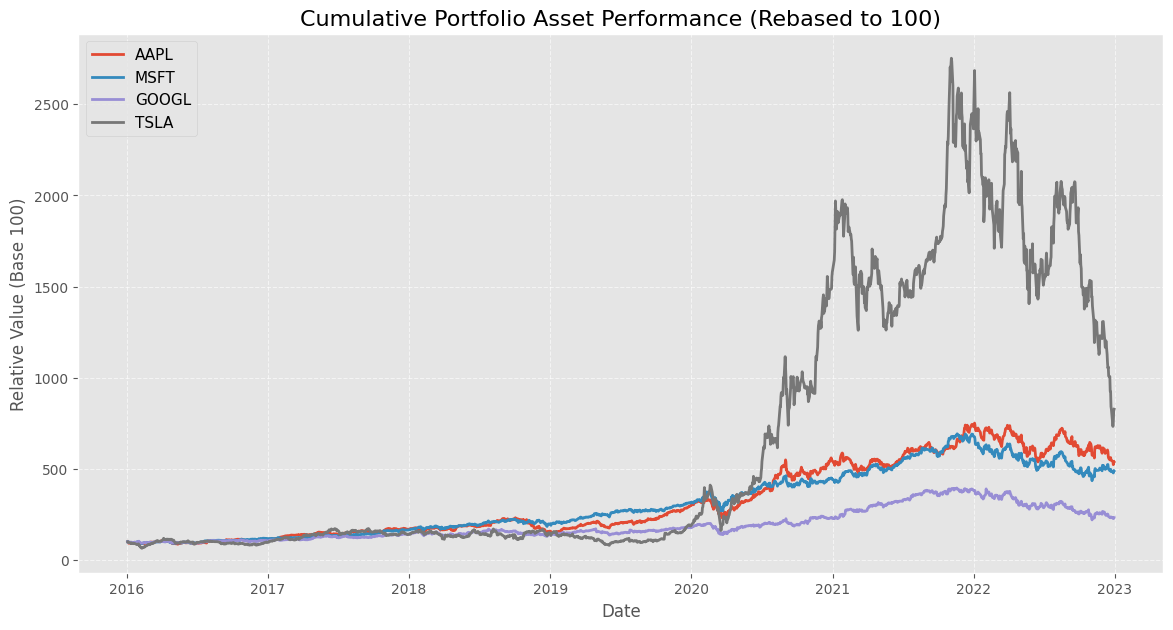

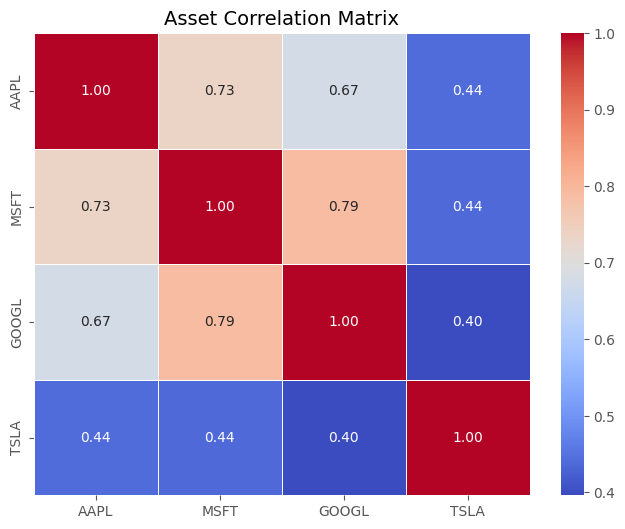

In [ ]:

# ---------------------------------------------------------
# Normalized Price Performance Graph
# ---------------------------------------------------------

plt.figure(figsize=(14, 7))

# Normalize data: (Price / Start_Price) * 100
# This shows the value of a $100 investment over time
normalized_data = (raw_data / raw_data.iloc[0]) * 100

# Loop through columns to plot each asset
for column in normalized_data.columns:
    plt.plot(normalized_data.index, normalized_data[column], label=column, linewidth=2)

plt.title('Cumulative Portfolio Asset Performance (Rebased to 100)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Value (Base 100)', fontsize=12)
plt.legend(loc='upper left', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

# ---------------------------------------------------------
# Correlation Matrix (Optional but Recommended)
# ---------------------------------------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(daily_returns.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Asset Correlation Matrix', fontsize=14)
plt.show()

The line graph above illustrates the growth of the assets over the selected time period.
- Assets with steeper upward slopes have generated higher returns.
- Assets with jagged, fluctuating lines exhibit higher volatility (risk).

The Heatmap below it shows how assets move in relation to one another. Lower correlation between assets generally aids in better diversification.

Now that we understand the data, we will proceed to calculate the **Annualized Mean Returns** and **Covariance Matrix** needed for the optimization algorithm.

### 7. Run Optimization
We calculate the statistical properties of the returns and pass them into our `optimize_portfolio` function.

In [ ]:
# Calculate inputs for optimization
mean_returns = daily_returns.mean()
cov_matrix = daily_returns.cov()

# Perform Optimization
opt_result = optimize_portfolio(mean_returns, cov_matrix, risk_free_rate)

# Extract results
optimal_weights = opt_result.x
opt_ret, opt_vol, opt_sharpe = calculate_portfolio_metrics(optimal_weights, mean_returns, cov_matrix, risk_free_rate)

print("Optimization Successful:", opt_result.success)
print(f"Maximized Sharpe Ratio: {opt_sharpe:.4f}")
print(f"Annualized Return:      {opt_ret:.4f}")
print(f"Annualized Volatility:  {opt_vol:.4f}")

Optimization Successful: True
Maximized Sharpe Ratio: 0.9878
Annualized Return:      0.3074
Annualized Volatility:  0.2909


The optimization is complete. We have the optimal weights. Finally, let's visualize the results to understand how the capital should be allocated among the selected assets.

### 8. Visualization
We will create a dataframe of the weights and plot a pie chart and bar chart to visualize the optimal portfolio composition.


--- Optimal Allocation ---
   Asset  Optimal Weight
0   AAPL          0.3621
1   MSFT          0.3272
3   TSLA          0.2107
2  GOOGL          0.1000


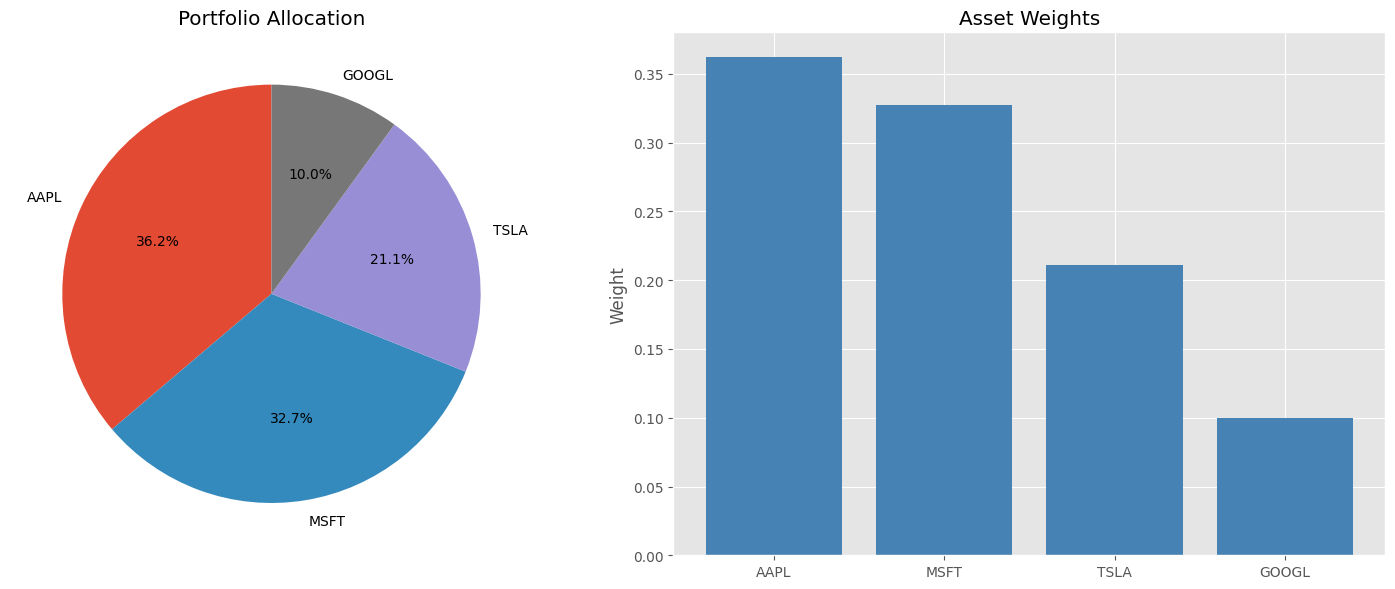

In [ ]:
# Create Results DataFrame
results_df = pd.DataFrame({
    'Asset': tickers,
    'Optimal Weight': optimal_weights
})
results_df['Optimal Weight'] = results_df['Optimal Weight'].round(4)
results_df = results_df.sort_values(by='Optimal Weight', ascending=False)

print("\n--- Optimal Allocation ---")
print(results_df)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Pie Chart
ax1.pie(results_df['Optimal Weight'], labels=results_df['Asset'], autopct='%1.1f%%', startangle=90)
ax1.set_title('Portfolio Allocation')

# Bar Chart
ax2.bar(results_df['Asset'], results_df['Optimal Weight'], color='steelblue')
ax2.set_title('Asset Weights')
ax2.set_ylabel('Weight')

plt.tight_layout()
plt.show()

### Conclusion
The charts above display the optimal asset allocation that maximizes the Sharpe Ratio for the given historical data. This notebook successfully combined data collection, preprocessing, and optimization into a single workflow.


## Data Analysis Key Findings
*   **Lowest Mean Daily Return for GOOGL**: GOOGL had the lowest mean daily return (0.000637) compared to other assets (AAPL: 0.001140, MSFT: 0.001058, TSLA: 0.001884).
*   **GOOGL's Risk Profile**: While GOOGL's individual volatility (from variance of 0.000315) was comparable to MSFT (0.000314) and lower than AAPL (0.000366) and TSLA (0.001371), this level of risk was not sufficiently low to compensate for its significantly lower return.
*   **Lack of Strong Diversification Benefit from GOOGL**: The positive covariances between GOOGL and other assets (e.g., 0.000229 with AAPL, 0.000249 with MSFT, 0.000261 with TSLA) indicated that it did not offer a significant negative correlation to reduce overall portfolio risk, which would be crucial to justify including a low-return asset.
*   **0% Allocation to GOOGL**: The optimization algorithm, aimed at maximizing the Sharpe Ratio, assigned a 0.0000 (0%) weight to GOOGL, concluding that it did not contribute positively to the portfolio's risk-adjusted returns compared to other available assets.

### Insights or Next Steps
*   For assets with lower returns, a significantly lower correlation to other assets or exceptionally low individual volatility would be required for their inclusion in a Sharpe Ratio-maximized portfolio.
*   Future analysis could explore portfolio optimization under different objectives (e.g., minimum variance, target return) or with additional constraints (e.g., sector allocation limits) to see if GOOGL's allocation changes.


## The Efficient Frontier

Now we generate the efficient frontier and visualize it. To achieve this, we will:

1.  Define a new objective function for volatility, `minimize_volatility_objective`, and a constraint function for target return, `target_return_constraint`, using the same annualization factor (252 trading days) as in the `calculate_portfolio_metrics` function.
2.  Iterate through a range of target returns, from the minimum volatility portfolio's return to the maximum Sharpe ratio portfolio's return. For each target return, we will use `scipy.optimize.minimize` to find the portfolio with the lowest volatility that achieves that return.
3.  Store the returns, volatilities, and Sharpe ratios of these efficient portfolios.
4.  Plot the efficient frontier, marking the minimum volatility and maximum Sharpe ratio portfolios on the graph.

## Define Target Return Objective Function

Create an objective function `minimize_volatility_objective` to return portfolio volatility and a constraint function `target_return_constraint` to enforce a specific target return. These functions will be used in the optimization process.


In [ ]:
def minimize_volatility_objective(weights, mean_returns, cov_matrix):
    """
    Objective function to minimize portfolio volatility.
    Uses calculate_portfolio_metrics to compute volatility.
    """
    # risk_free_rate is not relevant for volatility, so we pass 0.0
    _, portfolio_volatility, _ = calculate_portfolio_metrics(weights, mean_returns, cov_matrix, risk_free_rate=0.0)
    return portfolio_volatility

def target_return_constraint(weights, mean_returns, target_return):
    """
    Constraint function to enforce a specific target return.
    """
    # Calculate annualized portfolio return
    portfolio_return = np.sum(mean_returns * weights) * 252
    # The constraint is satisfied when this function returns 0
    return portfolio_return - target_return

print("Objective and constraint functions for target return optimization defined.")

Objective and constraint functions for target return optimization defined.


## Generating Efficient Frontier Portfolio
To generate the efficient frontier, we need to first define the optimization constraints and initial guess. Then, we will find the minimum volatility portfolio. After that, we will define a range of target returns from the minimum volatility portfolio's return to the maximum Sharpe ratio portfolio's return. Finally, we will iterate through this range, optimizing for the lowest volatility at each target return and storing the results.



In [ ]:
num_assets = len(mean_returns)

# Constraints for the optimization (common for both min vol and efficient frontier)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds for each asset's weight (0.10 to 0.40)
bounds = tuple((0.10, 0.40) for asset in range(num_assets))

# Initial guess: Equal weights
initial_guess = [1. / num_assets] * num_assets

# 1. Find the Minimum Volatility Portfolio
min_vol_result = minimize(minimize_volatility_objective,
                          initial_guess,
                          args=(mean_returns, cov_matrix),
                          method='SLSQP',
                          bounds=bounds,
                          constraints=constraints)

min_vol_weights = min_vol_result.x
min_vol_ret, min_vol_vol, min_vol_sharpe = calculate_portfolio_metrics(min_vol_weights, mean_returns, cov_matrix, risk_free_rate)

print(f"Minimum Volatility Portfolio:\n  Return: {min_vol_ret:.4f}\n  Volatility: {min_vol_vol:.4f}\n  Sharpe Ratio: {min_vol_sharpe:.4f}")

# 2. Generate a sequence of target returns for the Efficient Frontier
# The range should be from the min volatility portfolio's return to the max Sharpe ratio portfolio's return
target_returns = np.linspace(min_vol_ret, opt_ret, 100)

# Lists to store results for the Efficient Frontier
efficient_frontier_returns = []
efficient_frontier_volatilities = []
efficient_frontier_sharpe_ratios = []

# 3. Iterate through each target return to find efficient portfolios
for target_r in target_returns:
    # Define constraints for the current target return optimization
    ef_constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x: target_return_constraint(x, mean_returns, target_r)}
    )

    # Optimize for minimum volatility at the current target return
    ef_result = minimize(minimize_volatility_objective,
                         initial_guess,
                         args=(mean_returns, cov_matrix),
                         method='SLSQP',
                         bounds=bounds,
                         constraints=ef_constraints)

    if ef_result.success:
        ef_weights = ef_result.x
        ef_ret, ef_vol, ef_sharpe = calculate_portfolio_metrics(ef_weights, mean_returns, cov_matrix, risk_free_rate)
        e_ret, e_vol, e_sharpe = calculate_portfolio_metrics(ef_weights, mean_returns, cov_matrix, risk_free_rate)
        efficient_frontier_returns.append(e_ret)
        efficient_frontier_volatilities.append(e_vol)
        efficient_frontier_sharpe_ratios.append(e_sharpe)

# Convert lists to NumPy arrays
efficient_frontier_returns = np.array(efficient_frontier_returns)
efficient_frontier_volatilities = np.array(efficient_frontier_volatilities)
efficient_frontier_sharpe_ratios = np.array(efficient_frontier_sharpe_ratios)

print("\nEfficient Frontier portfolios generated.")

Minimum Volatility Portfolio:
  Return: 0.2508
  Volatility: 0.2676
  Sharpe Ratio: 0.8625

Efficient Frontier portfolios generated.


## Visualize Efficient Frontier

Now we plot the efficient frontier using the collected returns and volatilities. On the same plot, we mark the maximum Sharpe Ratio portfolio (already calculated) and the minimum volatility portfolio (already calculated).


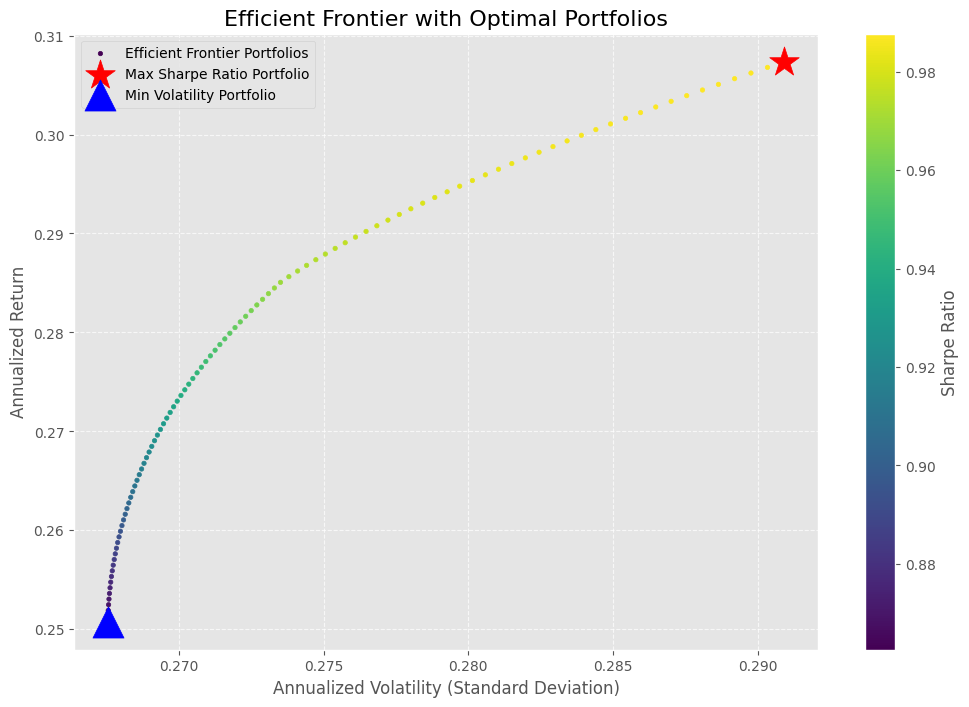

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(efficient_frontier_volatilities, efficient_frontier_returns, c=efficient_frontier_sharpe_ratios, cmap='viridis', marker='o', s=10, label='Efficient Frontier Portfolios')
plt.colorbar(label='Sharpe Ratio')

# Mark the Max Sharpe Ratio portfolio
plt.scatter(opt_vol, opt_ret, marker='*', color='red', s=500, label='Max Sharpe Ratio Portfolio')

# Mark the Minimum Volatility portfolio
plt.scatter(min_vol_vol, min_vol_ret, marker='^', color='blue', s=500, label='Min Volatility Portfolio')

plt.title('Efficient Frontier with Optimal Portfolios', fontsize=16)
plt.xlabel('Annualized Volatility (Standard Deviation)', fontsize=12)
plt.ylabel('Annualized Return', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


## Plot Capital Market Line (CML)

We will now add the Capital Market Line (CML) to the existing Efficient Frontier plot. The CML will originate from the risk-free rate on the y-axis (zero volatility) and pass through the Maximum Sharpe Ratio Portfolio. The slope of this line represents the maximum Sharpe Ratio achievable. We will use the previously calculated `risk_free_rate`, `opt_ret`, and `opt_vol` to define and plot the CML. The Maximum Sharpe Ratio Portfolio can be identified as the tangency point with the Efficient Frontier.

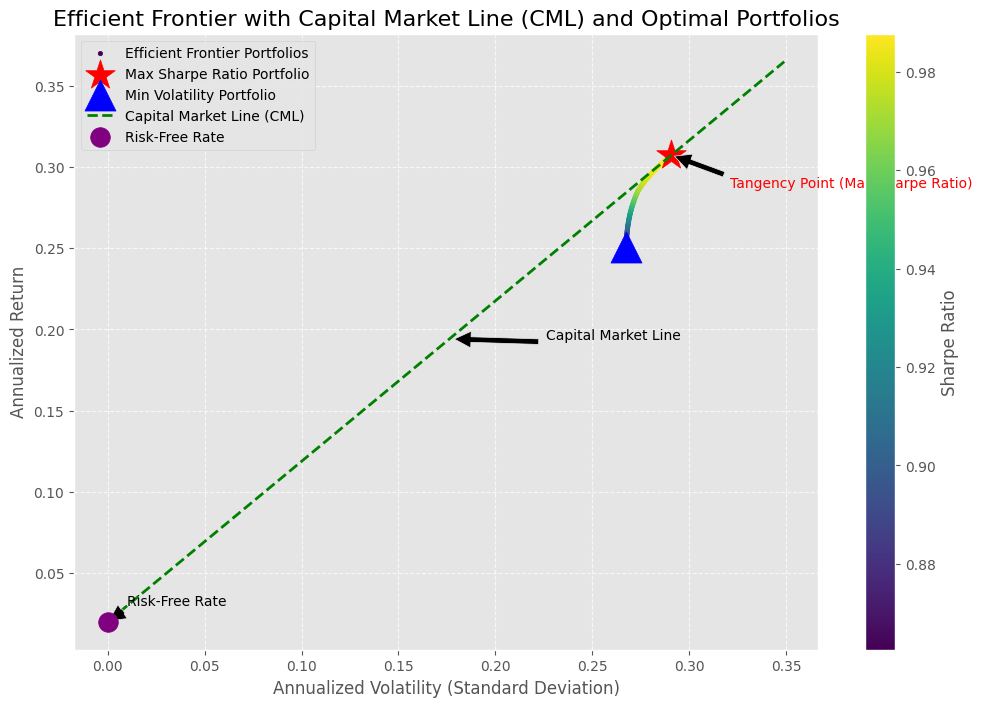

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(efficient_frontier_volatilities, efficient_frontier_returns, c=efficient_frontier_sharpe_ratios, cmap='viridis', marker='o', s=10, label='Efficient Frontier Portfolios')
plt.colorbar(label='Sharpe Ratio')

# Mark the Max Sharpe Ratio portfolio
plt.scatter(opt_vol, opt_ret, marker='*', color='red', s=500, label='Max Sharpe Ratio Portfolio')

# Mark the Minimum Volatility portfolio
plt.scatter(min_vol_vol, min_vol_ret, marker='^', color='blue', s=500, label='Min Volatility Portfolio')

# ---------------------------------------------------------
# Add Capital Market Line (CML)
# ---------------------------------------------------------

# 1. Define a range of volatility values for the CML
cml_volatility = np.linspace(0, opt_vol * 1.2, 100) # Extend slightly beyond opt_vol

# 2. Calculate the corresponding return values for the CML
cml_returns = risk_free_rate + ((opt_ret - risk_free_rate) / opt_vol) * cml_volatility

# 3. Plot the CML
plt.plot(cml_volatility, cml_returns, color='green', linestyle='--', linewidth=2, label='Capital Market Line (CML)')

# 4. Add a point on the y-axis at risk_free_rate
plt.scatter(0, risk_free_rate, marker='o', color='purple', s=200, label='Risk-Free Rate', zorder=5)

# 5. Add text annotations
plt.annotate('Risk-Free Rate', xy=(0, risk_free_rate), xytext=(0.01, risk_free_rate + 0.01),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10)
plt.annotate('Capital Market Line', xy=(cml_volatility[50], cml_returns[50]), xytext=(cml_volatility[50] + 0.05, cml_returns[50]),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10)
plt.annotate('Tangency Point (Max Sharpe Ratio)', xy=(opt_vol, opt_ret), xytext=(opt_vol + 0.03, opt_ret - 0.02),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10, color='red')

plt.title('Efficient Frontier with Capital Market Line (CML) and Optimal Portfolios', fontsize=16)
plt.xlabel('Annualized Volatility (Standard Deviation)', fontsize=12)
plt.ylabel('Annualized Return', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Explain CML and Max Sharpe Ratio

### Capital Market Line (CML)

The Capital Market Line (CML) is a graphical representation of the risk-return trade-off for efficient portfolios when a risk-free asset is available. It is a fundamental concept in Modern Portfolio Theory (MPT), extending the Efficient Frontier by incorporating the possibility of investing in or borrowing at a risk-free rate.

**Components of the CML:**

1.  **Risk-Free Rate ($R_f$):** This is the return on an investment with zero risk, often represented by the return on short-term government securities (e.g., U.S. Treasury bills). On the CML graph, it's the y-intercept, representing a portfolio with zero volatility and a return equal to $R_f$.

2.  **Market Risk Premium ($R_m - R_f$):** This is the additional return an investor expects to receive for taking on the average market risk, where $R_m$ is the expected return of the market portfolio.

3.  **Standard Deviation of the Market Portfolio ($\sigma_m$):** This measures the total risk (volatility) of the market portfolio.

The equation for the CML is:

$$ R_p = R_f + \frac{R_m - R_f}{\sigma_m} \sigma_p $$

Where:
*   $R_p$ is the expected return of any efficient portfolio on the CML.
*   $\sigma_p$ is the standard deviation (total risk) of that portfolio.
*   The term $\frac{R_m - R_f}{\sigma_m}$ represents the slope of the CML, which is essentially the Sharpe Ratio of the market portfolio.

### Significance in Modern Portfolio Theory

The CML is highly significant because it defines the **best possible risk-return trade-off** an investor can achieve. It represents the highest expected return for any given level of total risk (standard deviation) when combining a risk-free asset with any portfolio of risky assets. All portfolios on the CML are considered efficient" portfolios. Any portfolio lying below the CML is suboptimal, offering less return for the same level of risk, or higher risk for the same return. Any portfolio above the CML is unattainable. This makes the CML a benchmark for evaluating the efficiency of a portfolio.

### Tangency Point: The Maximum Sharpe Ratio Portfolio

The **tangency point** where the CML touches the Efficient Frontier is of paramount importance. This specific portfolio on the Efficient Frontier is known as the **Market Portfolio** (or sometimes the Tangency Portfolio). This portfolio is entirely composed of risky assets (no risk-free asset is held within it) and represents the most efficient combination of risky assets available to an investor.

**Why is it the Maximum Sharpe Ratio Portfolio?**

Geometrically, the Sharpe Ratio is the slope of the line connecting the risk-free rate to a given portfolio in a risk-return (standard deviation-return) plot. The CML is the steepest possible line that can be drawn from the risk-free rate to the Efficient Frontier. Therefore, the point at which the CML is tangent to the Efficient Frontier must correspond to the portfolio with the highest Sharpe Ratio among all possible portfolios of risky assets. This portfolio maximizes the excess return per unit of total risk.

### Investor Portfolio Construction with the CML

Investors can achieve any point on the CML by combining the risk-free asset with the Market Portfolio (the tangency portfolio) according to their individual risk tolerance:

*   **Lending (Lower Risk):** An investor with a lower risk tolerance can invest a portion of their capital in the risk-free asset and the remaining in the Market Portfolio. This forms a portfolio on the CML between the risk-free rate and the Market Portfolio. The further towards the risk-free rate, the lower the risk and return.

*   **Borrowing (Higher Risk):** An investor with a higher risk tolerance can borrow at the risk-free rate and invest more than 100% of their own capital into the Market Portfolio. This forms a portfolio on the CML beyond the Market Portfolio. While offering higher expected returns, it also incurs higher total risk (volatility) due to leverage.

In essence, the CML allows investors to tailor their risk exposure to their preferences while always holding the optimal combination of risky assets (the Market Portfolio) and the risk-free asset, thereby maximizing their return for any chosen level of total risk.

## Calculate Historical VaR

Now we define a function to calculate Historical Value at Risk (VaR) for a given portfolio's daily returns and a specified confidence level. This will involve computing the daily returns of the optimal portfolio based on its weights and then finding the percentile corresponding to the confidence level from the sorted historical returns.


In [ ]:
def calculate_historical_var(portfolio_returns, confidence_level=0.95):
    """
    Calculate Historical Value at Risk (VaR) for a given portfolio's daily returns
    and a specified confidence level. This involves calculating the appropriate percentile of the return distribution.

    Parameters:
    -----------
    portfolio_returns : pandas.Series or numpy.array
        Daily returns of the portfolio.
    confidence_level : float
        Desired confidence level (e.g., 0.95 for 95%).

    Returns:
    --------
    float
        Historical VaR value.
    """
    # Calculate the VaR level (e.g., for 95% confidence, var_level = 0.05)
    var_level = 1 - confidence_level

    # Calculate Historical VaR using the quantile method
    # VaR is typically expressed as a positive number representing a potential loss
    # The quantile will be a negative return, so we often take its absolute value
    # or present it as the negative of the quantile.
    historical_var = portfolio_returns.quantile(var_level)

    return historical_var

print("Function `calculate_historical_var` has been defined.")

Function `calculate_historical_var` has been defined.


## Calculate Parametric VaR

Now define a function to calculate Parametric (Variance-Covariance) Value at Risk (VaR) for a given portfolio, confidence level, and historical data. This method assumes a normal distribution of returns and uses the portfolio's mean return and standard deviation.


In [ ]:
from scipy.stats import norm

def calculate_parametric_var(portfolio_mean_return, portfolio_std_dev, confidence_level=0.95):
    """
    Calculate Parametric (Variance-Covariance) Value at Risk (VaR)
    for a given portfolio's mean return, standard deviation, and a specified confidence level.

    Parameters:
    -----------
    portfolio_mean_return : float
        The mean (average) return of the portfolio.
    portfolio_std_dev : float
        The standard deviation (volatility) of the portfolio.
    confidence_level : float
        Desired confidence level (e.g., 0.95 for 95%).

    Returns:
    --------
    float
        Parametric VaR value.
    """
    # Calculate the Z-score corresponding to the confidence level
    # For 95% confidence, we look for the 5th percentile (1 - 0.95 = 0.05)
    z_score = norm.ppf(1 - confidence_level)

    # Calculate Parametric VaR using the formula
    # VaR = Mean Return + Z-score * Standard Deviation
    # Note: VaR is typically presented as a positive loss, but the calculation here will be negative
    # if the mean return is positive. We'll return the calculated value, which is a return threshold.
    parametric_var = portfolio_mean_return + z_score * portfolio_std_dev

    return parametric_var

print("Function `calculate_parametric_var` has been defined.")

Function `calculate_parametric_var` has been defined.


## Apply VaR Calculations to Optimal Portfolio

Use the defined Historical and Parametric VaR functions to calculate the 1-day VaR for the optimal portfolio at 95% and 99% confidence levels. Display these calculated VaR values.


**Reasoning**:
I will calculate the daily returns of the optimal portfolio using the previously defined `daily_returns` and `optimal_weights`, then compute its mean and standard deviation. After that, I will apply both `calculate_historical_var` and `calculate_parametric_var` functions at 95% and 99% confidence levels to this optimal portfolio data and print the results.



In [ ]:
print("### 1. Optimal Portfolio Daily Returns")
# 1. Calculate the daily returns of the optimal portfolio
optimal_portfolio_daily_returns = (daily_returns * optimal_weights).sum(axis=1)
print("Optimal Portfolio Daily Returns calculated.")

print("\n### 2. Optimal Portfolio Mean and Standard Deviation")
# 2. Calculate the mean and standard deviation of optimal_portfolio_daily_returns
optimal_portfolio_mean_return = optimal_portfolio_daily_returns.mean()
optimal_portfolio_std_dev = optimal_portfolio_daily_returns.std()
print(f"Optimal Portfolio Mean Daily Return: {optimal_portfolio_mean_return:.6f}")
print(f"Optimal Portfolio Daily Standard Deviation: {optimal_portfolio_std_dev:.6f}")

print("\n### 3. Historical VaR Calculations")
# 3. Calculate Historical VaR for the optimal portfolio at a 95% confidence level
historical_var_95 = calculate_historical_var(optimal_portfolio_daily_returns, confidence_level=0.95)
print(f"Optimal Portfolio Historical VaR (95% confidence): {historical_var_95:.6f}")

# 4. Calculate Historical VaR for the optimal portfolio at a 99% confidence level
historical_var_99 = calculate_historical_var(optimal_portfolio_daily_returns, confidence_level=0.99)
print(f"Optimal Portfolio Historical VaR (99% confidence): {historical_var_99:.6f}")

print("\n### 4. Parametric VaR Calculations")
# 5. Calculate Parametric VaR for the optimal portfolio at a 95% confidence level
parametric_var_95 = calculate_parametric_var(optimal_portfolio_mean_return, optimal_portfolio_std_dev, confidence_level=0.95)
print(f"Optimal Portfolio Parametric VaR (95% confidence): {parametric_var_95:.6f}")

# 6. Calculate Parametric VaR for the optimal portfolio at a 99% confidence level
parametric_var_99 = calculate_parametric_var(optimal_portfolio_mean_return, optimal_portfolio_std_dev, confidence_level=0.99)
print(f"Optimal Portfolio Parametric VaR (99% confidence): {parametric_var_99:.6f}")


### 1. Optimal Portfolio Daily Returns
Optimal Portfolio Daily Returns calculated.

### 2. Optimal Portfolio Mean and Standard Deviation
Optimal Portfolio Mean Daily Return: 0.001220
Optimal Portfolio Daily Standard Deviation: 0.018325

### 3. Historical VaR Calculations
Optimal Portfolio Historical VaR (95% confidence): -0.029764
Optimal Portfolio Historical VaR (99% confidence): -0.047735

### 4. Parametric VaR Calculations
Optimal Portfolio Parametric VaR (95% confidence): -0.028923
Optimal Portfolio Parametric VaR (99% confidence): -0.041411


## Explanation of observed Value at Risk (VaR)

### 1. Fundamental Concept of Value at Risk (VaR)

**Value at Risk (VaR)** is a statistical measure used to quantify the level of financial risk within a firm or an investment portfolio over a specific time frame. It estimates the potential loss in value of a portfolio with a given probability over a defined time horizon.

*   **What it measures**: VaR quantifies the maximum potential loss that an investment or a portfolio could incur over a specified period, under normal market conditions, with a given confidence level.
    *   For example, a "1-day 95% VaR of -1 million" means there is a 5% chance that the portfolio will lose at least 1 million over the next day.

*   **Confidence Level**: This represents the probability that the actual loss will *not* exceed the VaR estimate. Common confidence levels are 95%, 99%, or 99.9%. A higher confidence level implies a more conservative (larger) VaR estimate.

*   **Time Horizon**: This is the period over which the potential loss is estimated. Common time horizons are 1 day, 10 days, or 1 month. The VaR generally increases with the time horizon, as there's more time for adverse events to occur.

### 2. Common Applications of VaR

VaR is widely used in finance and risk management for several purposes:

*   **Risk Measurement and Reporting**: Financial institutions (banks, investment funds) use VaR to aggregate and report their overall market risk exposure to regulators and internal stakeholders.
*   **Risk Management**: Traders and portfolio managers use VaR to set risk limits, monitor portfolio risk, and make informed decisions about position sizing and diversification.
*   **Capital Allocation**: Regulators often use VaR-based measures to determine the amount of capital banks and other financial firms must hold to cover potential losses.
*   **Performance Evaluation**: Risk-adjusted performance measures (e.g., Sharpe Ratio, VaR-adjusted return) often incorporate VaR to assess how efficiently a portfolio generates returns for the risk taken.

### 3. Key Limitations of VaR

Despite its widespread use, VaR has several important limitations:

*   **Does not measure worst-case loss**: VaR tells us the loss one can expect to exceed with a certain probability, but it doesn't say *how much* he or she could lose if that probability event occurs. It's a threshold, not a maximum possible loss. For example, a 95% VaR of -1 million means there's a 5% chance of losing 1 million *or more*, but it doesn't quantify how much the "or more" part is.
*   **Assumes normal distribution (for Parametric VaR)**: Parametric VaR relies on the assumption that asset returns are normally distributed. In reality, financial returns often exhibit "fat tails" (more extreme events than a normal distribution would predict) and skewness, leading to an underestimation of risk.
*   **Historical Data Dependence**: Historical VaR relies heavily on past market behavior. If future market conditions differ significantly from historical patterns (e.g., during a market crash or a regime change), historical VaR can be a poor predictor of future risk.
*   **Subadditivity Issue**: In some cases (especially with certain types of financial instruments like options), the VaR of a combined portfolio can be greater than the sum of the individual VaRs of its components, which violates the principle of subadditivity expected from a coherent risk measure.
*   **Manipulation**: VaR can sometimes be manipulated by portfolio managers to show lower risk, for instance, by selling out-of-the-money options to earn premium, which rarely hits the VaR threshold but can lead to massive losses during extreme events.

### 4. Interpretation of Historical VaR Results for the Optimal Portfolio

We calculated the 1-day Historical VaR for our optimal portfolio based on its simulated daily returns:

*   **Optimal Portfolio Historical VaR (95% confidence): -0.029764**
    *   This means that, based on historical daily return data, we can be 95% confident that the optimal portfolio's loss will not exceed **2.9764%** on any given day. Conversely, there is a 5% chance that the portfolio will experience a loss of **2.9764% or more** over a single day.

*   **Optimal Portfolio Historical VaR (99% confidence): -0.047735**
    *   Similarly, we can be 99% confident that the optimal portfolio's loss will not exceed **4.7735%** on any given day. This implies a 1% chance of experiencing a daily loss of **4.7735% or more**.

### 5. Interpretation of Parametric VaR Results for the Optimal Portfolio

We calculated the 1-day Parametric VaR assuming a normal distribution for our optimal portfolio's mean daily return and standard deviation:

*   **Optimal Portfolio Parametric VaR (95% confidence): -0.028923**
    *   Assuming normally distributed returns, there is a 5% chance that the optimal portfolio will lose **2.8923% or more** over a single day. This means we are 95% confident that losses will not exceed this value.

*   **Optimal Portfolio Parametric VaR (99% confidence): -0.041411**
    *   Assuming normally distributed returns, there is a 1% chance that the optimal portfolio will lose **4.1411% or more** over a single day. We are 99% confident that losses will not exceed this value.


### 6. Comparison of Calculated Results and Potential Discrepancies

| Confidence Level | Historical VaR | Parametric VaR | Difference (Parametric - Historical) |
| :--------------- | :------------- | :------------- | :----------------------------------- |
| **95%**          | -0.029764      | -0.028923      | 0.000841                             |
| **99%**          | -0.047735      | -0.041411      | 0.006324                             |

**Observations:**

*   At both 95% and 99% confidence levels, the **Historical VaR shows a larger potential loss (more negative)** than the Parametric VaR.
*   The **discrepancy increases significantly at the 99% confidence level**, where the Historical VaR is notably larger (more negative) than the Parametric VaR.

**Potential Reasons for Discrepancies:**

1.  **Non-Normal Distribution of Returns (Fat Tails)**: This is the most common reason. Financial returns, especially during periods of stress, tend to have "fat tails," meaning extreme negative (and positive) returns occur more frequently than a normal distribution would predict. The Historical VaR, by looking at actual past returns, captures these fat-tail events if they occurred in the historical period. The Parametric VaR, assuming normality, will underestimate these extreme losses.
2.  **Skewness**: If the return distribution is negatively skewed (more frequent small gains and a few large losses), the Parametric VaR (which typically assumes zero skew for simplicity or relies on a symmetric normal distribution) will likely underestimate the actual downside risk captured by historical data.
3.  **Specific Historical Events**: The historical data period (2016-01-01 to 2022-12-31) includes significant market events (e.g., COVID-19 crash, general market volatility). These extreme events, if captured in the tails of the historical distribution, will push the Historical VaR lower (more negative) compared to a model that assumes a smooth, normal distribution.

**Conclusion on Discrepancies:** The observed difference suggests that the optimal portfolio's daily returns likely do not perfectly follow a normal distribution. The larger difference at the 99% confidence level strongly indicates the presence of "fat tails" in the historical return data, where extreme losses are more common than a normal distribution would imply. In such cases, Historical VaR provides a more conservative and potentially realistic estimate of downside risk at higher confidence levels.

## Visualizing calculated VaR results
We now plot a histogram of the `optimal_portfolio_daily_returns` and superimpose vertical lines marking `historical_var_95`, `historical_var_99`, `parametric_var_95`, and `parametric_var_99`.


To ensure that all necessary VaR related variables are available for plotting and to verify their accessibility, we will first print their current values and then plot the results.



In [ ]:
print("--- Verifying VaR Data for Visualization ---")
print(f"optimal_portfolio_daily_returns (head):\n{optimal_portfolio_daily_returns.head()}")
print(f"historical_var_95: {historical_var_95:.6f}")
print(f"historical_var_99: {historical_var_99:.6f}")
print(f"parametric_var_95: {parametric_var_95:.6f}")
print(f"parametric_var_99: {parametric_var_99:.6f}")


--- Verifying VaR Data for Visualization ---
optimal_portfolio_daily_returns (head):
Date
2016-01-05   -0.007288
2016-01-06   -0.017459
2016-01-07   -0.032339
2016-01-08   -0.002986
2016-01-11    0.002827
dtype: float64
historical_var_95: -0.029764
historical_var_99: -0.047735
parametric_var_95: -0.028923
parametric_var_99: -0.041411


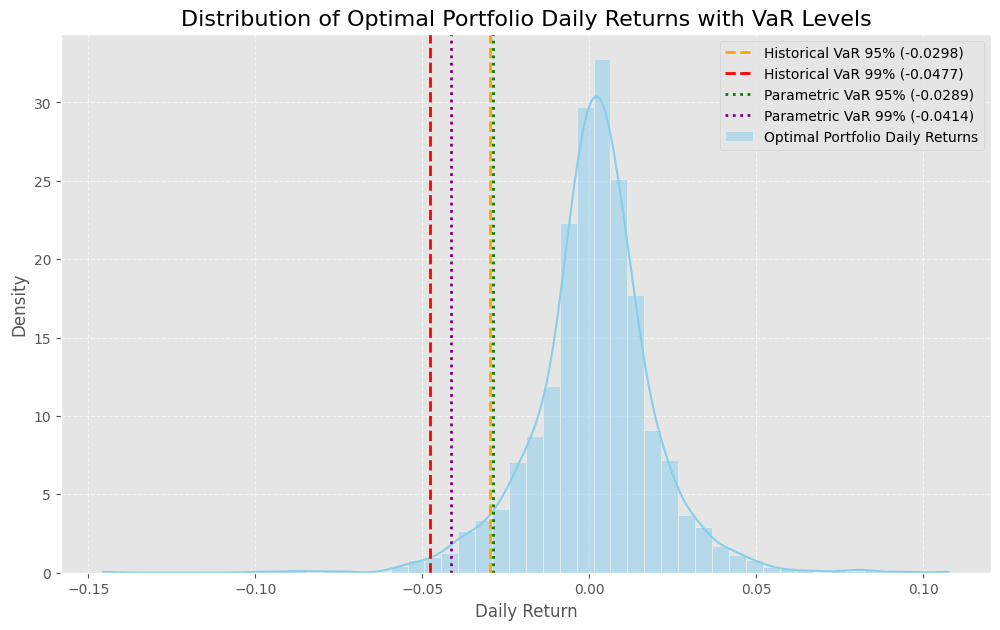

In [ ]:
plt.figure(figsize=(12, 7))
sns.histplot(optimal_portfolio_daily_returns, bins=50, kde=True, stat='density', color='skyblue', label='Optimal Portfolio Daily Returns')

# Plotting vertical lines for Historical VaR
plt.axvline(historical_var_95, color='orange', linestyle='--', linewidth=2, label=f'Historical VaR 95% ({historical_var_95:.4f})')
plt.axvline(historical_var_99, color='red', linestyle='--', linewidth=2, label=f'Historical VaR 99% ({historical_var_99:.4f})')

# Plotting vertical lines for Parametric VaR
plt.axvline(parametric_var_95, color='green', linestyle=':', linewidth=2, label=f'Parametric VaR 95% ({parametric_var_95:.4f})')
plt.axvline(parametric_var_99, color='purple', linestyle=':', linewidth=2, label=f'Parametric VaR 99% ({parametric_var_99:.4f})')

plt.title('Distribution of Optimal Portfolio Daily Returns with VaR Levels', fontsize=16)
plt.xlabel('Daily Return', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


## Develop Backtesting Framework (With Rolling Optimization)

Now we implement a robust backtesting mechanism with a rolling optimization process. It is crucial because it bridges between static historical testing and live trading. Instead of optimizing for the entire period, we optimize on a "rolling" window and test on subsequent period. This evaluates the stability and consistency of the optimization strategy across different market regimes, rather than just on a single, fixed dataset preventing overfitting.

In essence, rolling optimization acts like a continuously learning system that adjusts its 'understanding' of the market based on fresh, relevant data, making it more responsive to fundamental changes in market behavior known or regime shifts.




For this we will define the `window_size` and `rebalance_frequency`, initialize lists for rebalance dates and rolling optimal weights. Then terate through the `daily_returns` DataFrame, slice the data for each window, calculate mean returns and covariance matrix, optimize the portfolio, and store the results. Finally, we  will print a confirmation and display the first few rolling optimal weights.



In [ ]:
print("### Implementing Rolling Optimization for Backtesting")

# 1. Define window_size and rebalance_frequency
window_size = 252  # Approximately one year of trading days
rebalance_frequency = 21 # Approximately one month of trading days

# Initialize lists to store results
rebalance_dates = []
rolling_optimal_weights = []

num_assets = len(mean_returns)

# Bounds for each asset's weight (0.10 to 0.40) - consistent with previous optimization
bounds = tuple((0.10, 0.40) for asset in range(num_assets))
# Constraints: Sum of weights = 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Ensure risk_free_rate is a scalar
# The risk_free_rate is already a float, so .item() is not needed.
scalar_risk_free_rate = risk_free_rate

# 2. Iterate through daily_returns for rolling optimization
# The loop goes up to the point where a full window_size can be extracted
for i in range(0, len(daily_returns) - window_size, rebalance_frequency):
    # Get the data slice for the current window
    current_window_data = daily_returns.iloc[i : i + window_size]

    # Calculate mean_returns and cov_matrix for this window
    window_mean_returns = current_window_data.mean()
    window_cov_matrix = current_window_data.cov()

    # Initial guess: Equal weights for optimization in this window
    initial_guess = [1. / num_assets] * num_assets

    # Perform Optimization for the current window
    # Using the same optimization function defined earlier
    opt_result_window = minimize(lambda weights, mean_returns_arg, cov_matrix_arg, risk_free_rate_arg:
                                     -calculate_portfolio_metrics(weights, mean_returns_arg, cov_matrix_arg, risk_free_rate_arg)[2],
                                 initial_guess,
                                 args=(window_mean_returns, window_cov_matrix, scalar_risk_free_rate),
                                 method='SLSQP',
                                 bounds=bounds,
                                 constraints=constraints)

    if opt_result_window.success:
        # Store the optimal weights and the date at the end of the window
        rebalance_dates.append(current_window_data.index[-1])
        rolling_optimal_weights.append(opt_result_window.x)

print("\nRolling optimization completed.")
print(f"Number of rebalance points: {len(rebalance_dates)}")

# Display the first few rolling optimal weights
print("\nFirst 5 rolling optimal weights:")
for i, weights in enumerate(rolling_optimal_weights[:5]):
    print(f"  Date: {rebalance_dates[i].strftime('%Y-%m-%d')}, Weights: {np.round(weights, 4)}")

### Implementing Rolling Optimization for Backtesting

Rolling optimization completed.
Number of rebalance points: 72

First 5 rolling optimal weights:
  Date: 2017-01-03, Weights: [0.4 0.4 0.1 0.1]
  Date: 2017-02-02, Weights: [0.4    0.2638 0.1    0.2362]
  Date: 2017-03-06, Weights: [0.4    0.3826 0.1    0.1174]
  Date: 2017-04-04, Weights: [0.4 0.4 0.1 0.1]
  Date: 2017-05-04, Weights: [0.4    0.3966 0.1034 0.1   ]


## Evaluate Backtest Performance

Evaluate the out-of-sample performance of the rebalanced portfolios by calculating cumulative returns, annualized returns, drawdown analysis, and volatility over the entire backtesting period. Compare these metrics against a chosen benchmark (e.g., an equally weighted portfolio).



The first step is to convert the list of `rolling_optimal_weights` into a DataFrame and set `rebalance_dates` as its index, which is essential for further calculations.



In [ ]:
print("### 1. Convert rolling_optimal_weights to DataFrame")

# Convert list of arrays to DataFrame
rolling_weights_df = pd.DataFrame(rolling_optimal_weights, index=rebalance_dates, columns=tickers)

print("Rolling optimal weights DataFrame created.")
print("\n--- Rolling Weights DataFrame (Head) ---")
print(rolling_weights_df.head())

### 1. Convert rolling_optimal_weights to DataFrame
Rolling optimal weights DataFrame created.

--- Rolling Weights DataFrame (Head) ---
            AAPL      MSFT     GOOGL      TSLA
2017-01-03   0.4  0.400000  0.100000  0.100000
2017-02-02   0.4  0.263760  0.100000  0.236240
2017-03-06   0.4  0.382561  0.100000  0.117439
2017-04-04   0.4  0.400000  0.100000  0.100000
2017-05-04   0.4  0.396572  0.103428  0.100000



We need to align the `rolling_weights_df` with the full `daily_returns` index and then forward-fill the weights to apply them correctly to the out-of-sample period.



In [ ]:
print("### 2. Prepare weights for daily application (forward-fill)")

# Reindex rolling_weights_df to align with daily_returns dates
# This will introduce NaNs for dates between rebalance points
applied_weights_df = rolling_weights_df.reindex(daily_returns.index)

# Forward-fill the weights so that weights are held constant until the next rebalance date
# This ensures that for every daily_return, there's a corresponding weight
applied_weights_df = applied_weights_df.ffill().dropna()

print("Applied weights DataFrame created and forward-filled.")
print("\n--- Applied Weights DataFrame (Head) ---")
print(applied_weights_df.head())
print("\n--- Applied Weights DataFrame (Tail) ---")
print(applied_weights_df.tail())

### 2. Prepare weights for daily application (forward-fill)
Applied weights DataFrame created and forward-filled.

--- Applied Weights DataFrame (Head) ---
            AAPL  MSFT  GOOGL  TSLA
Date                               
2017-01-03   0.4   0.4    0.1   0.1
2017-01-04   0.4   0.4    0.1   0.1
2017-01-05   0.4   0.4    0.1   0.1
2017-01-06   0.4   0.4    0.1   0.1
2017-01-09   0.4   0.4    0.1   0.1

--- Applied Weights DataFrame (Tail) ---
            AAPL  MSFT  GOOGL  TSLA
Date                               
2022-12-23   0.4   0.4    0.1   0.1
2022-12-27   0.4   0.4    0.1   0.1
2022-12-28   0.4   0.4    0.1   0.1
2022-12-29   0.4   0.4    0.1   0.1
2022-12-30   0.4   0.4    0.1   0.1


Now that the weights are applied daily, we will calculate the daily returns of the backtested portfolio by multiplying the `daily_returns` DataFrame with the `applied_weights_df` and summing across assets, then compute the cumulative returns.



In [ ]:
print("### 3. Calculate Daily and Cumulative Returns for Backtested Portfolio")

# Align daily_returns with applied_weights_df to ensure matching dates
# This also handles cases where applied_weights_df might start later than daily_returns
common_index = daily_returns.index.intersection(applied_weights_df.index)
backtested_daily_returns_aligned = daily_returns.loc[common_index]
applied_weights_df_aligned = applied_weights_df.loc[common_index]

# Calculate daily returns of the backtested portfolio
backtested_portfolio_daily_returns = (backtested_daily_returns_aligned * applied_weights_df_aligned).sum(axis=1)

# Calculate cumulative returns
backtested_portfolio_cumulative_returns = (1 + backtested_portfolio_daily_returns).cumprod() - 1

print("Backtested portfolio daily and cumulative returns calculated.")
print("\n--- Backtested Portfolio Daily Returns (Head) ---")
print(backtested_portfolio_daily_returns.head())
print("\n--- Backtested Portfolio Cumulative Returns (Head) ---")
print(backtested_portfolio_cumulative_returns.head())

### 3. Calculate Daily and Cumulative Returns for Backtested Portfolio
Backtested portfolio daily and cumulative returns calculated.

--- Backtested Portfolio Daily Returns (Head) ---
Date
2017-01-03    0.007480
2017-01-04    0.002341
2017-01-05    0.002578
2017-01-06    0.010422
2017-01-09    0.003621
dtype: float64

--- Backtested Portfolio Cumulative Returns (Head) ---
Date
2017-01-03    0.007480
2017-01-04    0.009839
2017-01-05    0.012442
2017-01-06    0.022995
2017-01-09    0.026699
dtype: float64



Now that I have the daily returns for the backtested portfolio, we will calculate its annualized return and annualized volatility.



In [ ]:
print("### 4. Calculate Annualized Return and Volatility for Backtested Portfolio")

# Number of trading days in a year
num_trading_days = 252

# Calculate annualized return
backtested_annualized_return = (1 + backtested_portfolio_daily_returns).prod()**(num_trading_days/len(backtested_portfolio_daily_returns)) - 1

# Calculate annualized volatility
backtested_annualized_volatility = backtested_portfolio_daily_returns.std() * np.sqrt(num_trading_days)

print(f"Backtested Portfolio Annualized Return: {backtested_annualized_return:.4f}")
print(f"Backtested Portfolio Annualized Volatility: {backtested_annualized_volatility:.4f}")

### 4. Calculate Annualized Return and Volatility for Backtested Portfolio
Backtested Portfolio Annualized Return: 0.3273
Backtested Portfolio Annualized Volatility: 0.3228



To compare the backtested portfolio's performance, we will create an equally weighted benchmark portfolio, calculate its daily and cumulative returns, and then its annualized return and volatility.



In [ ]:
print("### 5. Calculate Performance Metrics for Equally Weighted Benchmark Portfolio")

# Create an equally weighted benchmark portfolio
# Ensure `daily_returns` and `applied_weights_df` cover the same date range for fair comparison

# The benchmark should use the same date range as the backtested portfolio
# which is determined by `common_index` from previous steps
benchmark_daily_returns_aligned = daily_returns.loc[common_index]

# Calculate daily returns of the equally weighted benchmark portfolio
equally_weighted_daily_returns = benchmark_daily_returns_aligned.mean(axis=1)

# Calculate cumulative returns for the benchmark
equally_weighted_cumulative_returns = (1 + equally_weighted_daily_returns).cumprod() - 1

# Calculate annualized return for the benchmark
equally_weighted_annualized_return = (1 + equally_weighted_daily_returns).prod()**(num_trading_days/len(equally_weighted_daily_returns)) - 1

# Calculate annualized volatility for the benchmark
equally_weighted_annualized_volatility = equally_weighted_daily_returns.std() * np.sqrt(num_trading_days)

print("Equally weighted benchmark portfolio metrics calculated.")
print(f"Equally Weighted Benchmark Annualized Return: {equally_weighted_annualized_return:.4f}")
print(f"Equally Weighted Benchmark Annualized Volatility: {equally_weighted_annualized_volatility:.4f}")

### 5. Calculate Performance Metrics for Equally Weighted Benchmark Portfolio
Equally weighted benchmark portfolio metrics calculated.
Equally Weighted Benchmark Annualized Return: 0.3249
Equally Weighted Benchmark Annualized Volatility: 0.3091



We need to calculate the maximum drawdown for both the backtested portfolio and the equally weighted benchmark portfolio. We will first define a function to calculate maximum drawdown and then apply it.



In [ ]:
print("### 6. Calculate Maximum Drawdown for Backtested and Benchmark Portfolios")

def calculate_max_drawdown(cumulative_returns):
    """
    Calculate the maximum drawdown for a given series of cumulative returns.
    """
    # Add 1 to cumulative returns to get total wealth index (start at 1)
    wealth_index = (1 + cumulative_returns)

    # Calculate the running maximum wealth
    running_max = wealth_index.cummax()

    # Calculate the drawdown
    drawdown = (wealth_index / running_max) - 1

    # Calculate the maximum drawdown
    max_drawdown = drawdown.min()
    return max_drawdown

# Calculate max drawdown for the backtested portfolio
backtested_max_drawdown = calculate_max_drawdown(backtested_portfolio_cumulative_returns)
print(f"Backtested Portfolio Maximum Drawdown: {backtested_max_drawdown:.4f}")

# Calculate max drawdown for the equally weighted benchmark portfolio
equally_weighted_max_drawdown = calculate_max_drawdown(equally_weighted_cumulative_returns)
print(f"Equally Weighted Benchmark Maximum Drawdown: {equally_weighted_max_drawdown:.4f}")

### 6. Calculate Maximum Drawdown for Backtested and Benchmark Portfolios
Backtested Portfolio Maximum Drawdown: -0.4314
Equally Weighted Benchmark Maximum Drawdown: -0.4475



All performance metrics (annualized return, annualized volatility, and maximum drawdown) for both the backtested and benchmark portfolios have been calculated. The final step now is to print and compare these metrics, which we will do by consolidating them into a pandas DataFrame for clear presentation.



In [ ]:
print("### 7. Compare Performance Metrics (Backtested vs. Benchmark)")

performance_data = {
    'Metric': ['Annualized Return', 'Annualized Volatility', 'Max Drawdown'],
    'Backtested Portfolio': [
        backtested_annualized_return,
        backtested_annualized_volatility,
        backtested_max_drawdown
    ],
    'Equally Weighted Benchmark': [
        equally_weighted_annualized_return,
        equally_weighted_annualized_volatility,
        equally_weighted_max_drawdown
    ]
}

performance_df = pd.DataFrame(performance_data)

# Round values for better readability
performance_df['Backtested Portfolio'] = performance_df['Backtested Portfolio'].round(4)
performance_df['Equally Weighted Benchmark'] = performance_df['Equally Weighted Benchmark'].round(4)

print("\n--- Performance Comparison ---")
print(performance_df.to_string(index=False))

### 7. Compare Performance Metrics (Backtested vs. Benchmark)

--- Performance Comparison ---
               Metric  Backtested Portfolio  Equally Weighted Benchmark
    Annualized Return                0.3273                      0.3249
Annualized Volatility                0.3228                      0.3091
         Max Drawdown               -0.4314                     -0.4475


## Introduce Factor Model Integration

For the factor model integration we will implicitly use a single-factor model, specifically the core concept from the Capital Asset Pricing Model (CAPM). We focus on calculating the beta of each asset against a market benchmark (the S&P 500).

For this we will fetch historical market data (S&P 500), calculate its daily returns, and align these market returns with the existing portfolio's daily returns to ensure a consistent date range for subsequent rolling beta calculations.


## Calculate Rolling Betas

To understand how individual assets in the portfolio react to overall market movements over time, we will calculate **rolling betas**. Beta is a measure of an asset's volatility in relation to the overall market (represented here by the S&P 500 index).

*   A beta greater than 1 indicates the asset is more volatile than the market.
*   A beta less than 1 indicates the asset is less volatile than the market.
*   A beta of 1 means the asset's price moves with the market.

We will use a 1-year (252 trading days) rolling window to capture changes in beta over time, re-calculating it approximately every month (`rebalance_frequency`). This provides a dynamic view of each asset's market sensitivity, which can be valuable for risk management and portfolio rebalancing decisions.


In [ ]:
print('### Fetching S&P 500 data and calculating daily returns.')

# 1. Fetch historical data for the S&P 500 index (ticker ^GSPC)
market_data = yf.download('^GSPC', start=start_date, end=end_date, progress=False)

# 2. Calculate the daily returns of the S&P 500 index
market_daily_returns = market_data['Close'].pct_change().dropna()

# 3. Align market_daily_returns with the daily_returns DataFrame of the portfolio assets
# Find the common index (dates) between portfolio and market returns
common_index_for_beta = daily_returns.index.intersection(market_daily_returns.index)

# Align both DataFrames/Series to this common index
aligned_daily_returns = daily_returns.loc[common_index_for_beta]
aligned_market_daily_returns = market_daily_returns.loc[common_index_for_beta]

print("S&P 500 data fetched and aligned with portfolio returns.")
print("\n--- Aligned Market Daily Returns (Head) ---")
print(aligned_market_daily_returns.head())
print("\n--- Aligned Portfolio Daily Returns (Head) ---")
print(aligned_daily_returns.head())

### Fetching S&P 500 data and calculating daily returns.
S&P 500 data fetched and aligned with portfolio returns.

--- Aligned Market Daily Returns (Head) ---
Ticker         ^GSPC
Date                
2016-01-05  0.002012
2016-01-06 -0.013115
2016-01-07 -0.023700
2016-01-08 -0.010838
2016-01-11  0.000853

--- Aligned Portfolio Daily Returns (Head) ---
                AAPL      MSFT     GOOGL      TSLA
Date                                              
2016-01-05 -0.025059  0.004562  0.002752  0.000090
2016-01-06 -0.019570 -0.018166 -0.002889 -0.019648
2016-01-07 -0.042204 -0.034782 -0.024140 -0.015477
2016-01-08  0.005288  0.003067 -0.013617 -0.021563
2016-01-11  0.016192 -0.000573  0.002955 -0.014929


/tmp/ipython-input-2282321051.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  market_data = yf.download('^GSPC', start=start_date, end=end_date, progress=False)



To calculate the rolling beta for each asset against the market using a 1-year window, we will iterate through the aligned daily returns data, extract a window of data for both asset and market returns, and then calculate the beta for each asset using linear regression for that window. The calculated betas will be stored in a DataFrame.



In [ ]:
print('### Calculating rolling betas for each asset.')

# 4. Initialize an empty DataFrame to store the rolling betas
rolling_betas = pd.DataFrame(columns=tickers)

# Ensure market_daily_returns is a Series (it might be a DataFrame from yfinance)
market_returns_series = aligned_market_daily_returns.squeeze()

# 5. Iterate through the aligned_daily_returns DataFrame using a rolling window
# The loop goes up to the point where a full window_size can be extracted
for i in range(0, len(aligned_daily_returns) - window_size, rebalance_frequency):
    # Get the data slice for the current window for both assets and market
    window_end_date = aligned_daily_returns.index[i + window_size - 1]

    asset_returns_window = aligned_daily_returns.iloc[i : i + window_size]
    market_returns_window = market_returns_series.iloc[i : i + window_size]

    # Check if there's enough data in the window for meaningful calculation
    if len(asset_returns_window) < window_size or len(market_returns_window) < window_size:
        continue

    # Store betas for the current window
    current_window_betas = {}
    # 7. For each asset within the window, calculate its beta
    for asset in tickers:
        # Ensure market_returns_window is not constant (std dev > 0)
        if market_returns_window.std() > 0:
            # Calculate beta using linear regression (covariance / variance of market)
            # Alternatively, using polyfit for simple linear regression
            beta, _ = np.polyfit(market_returns_window, asset_returns_window[asset], 1)
            current_window_betas[asset] = beta
        else:
            current_window_betas[asset] = np.nan # Assign NaN if market returns are constant

    # 8. Store the calculated rolling betas along with the corresponding dates
    rolling_betas.loc[window_end_date] = current_window_betas

print("Rolling betas calculated.")
print("\n--- Rolling Betas (Head) ---")
print(rolling_betas.head())
print("\n--- Rolling Betas (Tail) ---")
print(rolling_betas.tail())

### Calculating rolling betas for each asset.
Rolling betas calculated.

--- Rolling Betas (Head) ---
                AAPL      MSFT     GOOGL      TSLA
2017-01-03  1.020889  1.235189  0.964721  1.172015
2017-02-02  0.864451  1.176499  1.000800  1.165727
2017-03-06  0.834299  1.146938  0.999667  0.985477
2017-04-04  0.841518  1.153482  1.002984  0.991591
2017-05-04  0.839674  1.147165  1.016952  0.858730

--- Rolling Betas (Tail) ---
                AAPL      MSFT     GOOGL      TSLA
2022-08-05  1.271455  1.245635  1.327998  1.971449
2022-09-06  1.257572  1.236913  1.335764  1.938287
2022-10-05  1.236546  1.211211  1.312048  1.840137
2022-11-03  1.267447  1.249039  1.316330  1.822425
2022-12-05  1.305712  1.284040  1.331255  1.824529



The rolling betas have been calculated and provide a dynamic perspective on each asset's sensitivity to market movements. These values can fluctuate over time due to various factors, including company-specific news, industry trends, and broader economic conditions.

*   **Insights from Rolling Betas**: Observing how an asset's beta changes can inform tactical asset allocation. For instance, if an asset's beta increases significantly, it implies higher market risk, which might warrant a reduction in its weight if the investor is risk-averse.
*   **Future Applications**: Rolling betas are crucial for advanced portfolio strategies, including active risk management, hedging, and factor-based investing. They help in understanding and managing the systematic risk contribution of each asset to the overall portfolio.

## Implement Stress Testing and Scenario Analysis


We will now define a function `simulate_stressed_returns` that applies various stress parameters (market shock, volatility increase, asset-specific shocks) to the historical daily returns, weighted by the optimal portfolio weights to simulate how the optimized portfolio would perform under these specific scenarios.

In [ ]:
def simulate_stressed_returns(optimal_weights, daily_returns, scenario):
    """
    Simulates portfolio returns under a defined stress scenario.

    Parameters:
    -----------
    optimal_weights : numpy.ndarray
        Optimal weights of the portfolio assets.
    daily_returns : pandas.DataFrame
        Historical daily returns of the portfolio assets.
    scenario : dict
        Dictionary defining the stress scenario with keys like:
        'market_shock_pct': overall market percentage drop (e.g., -0.10 for 10% drop)
        'volatility_multiplier': factor to multiply historical volatility (e.g., 1.5 for 50% increase)
        'asset_specific_shocks': dict of asset: shock_pct (e.g., {'AAPL': -0.05})

    Returns:
    --------
    pandas.Series
        Simulated daily returns of the portfolio under the stress scenario.
    """

    # Make a copy to avoid modifying original daily_returns
    stressed_daily_returns = daily_returns.copy()

    # Apply market shock: a percentage drop applied uniformly
    if 'market_shock_pct' in scenario and scenario['market_shock_pct'] != 0:
        stressed_daily_returns = stressed_daily_returns * (1 + scenario['market_shock_pct'])

    # Apply volatility multiplier: Scale deviations from mean returns
    if 'volatility_multiplier' in scenario and scenario['volatility_multiplier'] != 1:
        mean_daily_returns = stressed_daily_returns.mean()
        stressed_daily_returns = mean_daily_returns + (stressed_daily_returns - mean_daily_returns) * scenario['volatility_multiplier']

    # Apply asset-specific shocks
    if 'asset_specific_shocks' in scenario:
        for asset, shock_pct in scenario['asset_specific_shocks'].items():
            if asset in stressed_daily_returns.columns:
                stressed_daily_returns[asset] = stressed_daily_returns[asset] * (1 + shock_pct)

    # Calculate the simulated portfolio daily returns using optimal weights
    simulated_portfolio_returns = (stressed_daily_returns * optimal_weights).sum(axis=1)

    return simulated_portfolio_returns

print("Function `simulate_stressed_returns` has been defined.")

Function `simulate_stressed_returns` has been defined.



The next step is to define at least two distinct stress scenarios as Python dictionaries.



In [ ]:
print('### Defining Stress Scenarios')

# Scenario 1: Severe Market Downturn
scenario_market_downturn = {
    'name': 'Severe Market Downturn (10% drop, 2x Volatility)',
    'market_shock_pct': -0.10,  # 10% market-wide drop
    'volatility_multiplier': 2.0, # Double the volatility
    'asset_specific_shocks': {}  # No specific asset shocks in this scenario
}

# Scenario 2: Tech Sector Crash
scenario_tech_crash = {
    'name': 'Tech Sector Crash (AAPL/MSFT -15%, TSLA -20%)',
    'market_shock_pct': 0, # No general market shock
    'volatility_multiplier': 1.0, # Normal volatility
    'asset_specific_shocks': {
        'AAPL': -0.15, # Apple drops by 15%
        'MSFT': -0.15, # Microsoft drops by 15%
        'GOOGL': -0.10, # Google drops by 10%
        'TSLA': -0.20  # Tesla drops by 20% (higher beta, typically more volatile)
    }
}

# Scenario 3: Mixed Stress (Moderate Market + Specific Asset Volatility)
scenario_mixed_stress = {
    'name': 'Mixed Stress (5% Market drop, TSLA -25% with 1.5x Volatility)',
    'market_shock_pct': -0.05, # 5% market-wide drop
    'volatility_multiplier': 1.5, # Increase overall volatility by 50%
    'asset_specific_shocks': {
        'TSLA': -0.25 # Tesla experiences an additional 25% drop
    }
}

print("Stress scenarios defined.")

### Defining Stress Scenarios
Stress scenarios defined.



We now need to apply the `simulate_stressed_returns` function to the optimal portfolio for each defined stress scenario. This will involve iterating through the scenarios, calculating the simulated daily returns, and then computing key performance indicators for each scenario.



In [ ]:
print('### Applying Stress Scenarios and Calculating Performance Metrics')

# List of all defined scenarios
scenarios = [
    scenario_market_downturn,
    scenario_tech_crash,
    scenario_mixed_stress
]

# Dictionary to store results for each scenario
scenario_results = {}

for scenario in scenarios:
    print(f"\n--- Simulating Scenario: {scenario['name']} ---")

    # 1. Apply the simulation function to get stressed portfolio daily returns
    stressed_portfolio_returns = simulate_stressed_returns(
        optimal_weights,
        daily_returns,
        scenario
    )

    # 2. Calculate key performance indicators for the stressed portfolio
    # Cumulative Return
    stressed_cumulative_return = (1 + stressed_portfolio_returns).prod() - 1

    # Maximum Drawdown
    # First, calculate cumulative returns (wealth index starting from 1)
    stressed_wealth_index = (1 + stressed_portfolio_returns).cumprod()
    stressed_running_max = stressed_wealth_index.cummax()
    stressed_drawdown = (stressed_wealth_index / stressed_running_max) - 1
    stressed_max_drawdown = stressed_drawdown.min()

    # Worst Single-Day Loss
    stressed_worst_single_day_loss = stressed_portfolio_returns.min()

    # Store the results
    scenario_results[scenario['name']] = {
        'Simulated Daily Returns': stressed_portfolio_returns,
        'Cumulative Return': stressed_cumulative_return,
        'Max Drawdown': stressed_max_drawdown,
        'Worst Single-Day Loss': stressed_worst_single_day_loss
    }

    print(f"  Cumulative Return: {stressed_cumulative_return:.4f}")
    print(f"  Max Drawdown: {stressed_max_drawdown:.4f}")
    print(f"  Worst Single-Day Loss: {stressed_worst_single_day_loss:.4f}")

print("\nStress test simulation and performance metric calculation completed for all scenarios.")

### Applying Stress Scenarios and Calculating Performance Metrics

--- Simulating Scenario: Severe Market Downturn (10% drop, 2x Volatility) ---
  Cumulative Return: 1.6234
  Max Drawdown: -0.7372
  Worst Single-Day Loss: -0.2632

--- Simulating Scenario: Tech Sector Crash (AAPL/MSFT -15%, TSLA -20%) ---
  Cumulative Return: 3.8919
  Max Drawdown: -0.3539
  Worst Single-Day Loss: -0.1224

--- Simulating Scenario: Mixed Stress (5% Market drop, TSLA -25% with 1.5x Volatility) ---
  Cumulative Return: 2.9027
  Max Drawdown: -0.5675
  Worst Single-Day Loss: -0.1940

Stress test simulation and performance metric calculation completed for all scenarios.


## Portfolio Stress Test Analysis

This analysis evaluates the portfolio's resilience across three hypothetical adverse scenarios. These results highlight the difference between long-term growth potential and short-term vulnerability to extreme market shocks.

---

### 📉 Scenario 1: Severe Market Downturn
**Conditions:** 10% market-wide drop + 200% increase in overall market volatility.

| Metric | Result | Analysis |
| :--- | :--- | :--- |
| **Cumulative Return** | **1.6234** | Despite shocks, the portfolio ends **162.34%** higher than the start over the full historical period. |
| **Max Drawdown** | **-0.7372** | **Critical Risk:** The portfolio loses **~73.72%** of its value from peak to trough, indicating extreme systemic vulnerability. |
| **Worst Day** | **-0.2632** | A single-day crash of **26.32%**, reflecting the impact of doubled volatility. |

---

### 💻 Scenario 2: Tech Sector Crash
**Conditions:** Asset-specific shocks to tech holdings (AAPL, MSFT, GOOGL, TSLA) ranging from -10% to -20%.

| Metric | Result | Analysis |
| :--- | :--- | :--- |
| **Cumulative Return** | **3.8919** | Long-term growth remains robust at **389.19%** as non-tech factors provide a buffer. |
| **Max Drawdown** | **-0.3539** | A **35.39%** drawdown is substantial but significantly safer than a total market collapse. |
| **Worst Day** | **-0.1224** | The simultaneous drop in major tech holdings results in a **12.24%** daily loss. |

---

### 🌪️ Scenario 3: Mixed Stress
**Conditions:** 5% market drop + 50% volatility increase + 25% specific crash in TSLA.

| Metric | Result | Analysis |
| :--- | :--- | :--- |
| **Cumulative Return** | **2.9027** | Reflects a middle-ground performance (**290.27%**) between the systemic and sector-specific scenarios. |
| **Max Drawdown** | **-0.5675** | **Severe:** A **56.75%** loss shows how a moderate market dip compounded by a volatile asset (TSLA) creates deep erosion. |
| **Worst Day** | **-0.1940** | The confluence of factors leads to a sharp **19.40%** single-day decline. |

---

### 🔍 Key Insights & Risk Assessment

* **Vulnerability to Systemic Risk:** Despite being optimized for the Sharpe Ratio, the portfolio is highly susceptible to broad market downturns. A **-73% drawdown** suggests that diversification within the current asset class may be insufficient to protect against systemic "black swan" events.
* **The "Tesla" Effect:** Scenario 3 highlights how a single, high-beta asset like **TSLA** can disproportionately drive portfolio drawdowns when combined with even moderate market stress.
* **Scenario-Dependent Risk:** The divergence in results proves that "risk" is not a single number. The portfolio handles sector-specific shocks (Tech) much better than it handles general market volatility and systemic liquidity events.

> **Conclusion:** These results suggest a need to explore further diversification (e.g., non-equity assets) or hedging strategies to mitigate the high maximum drawdowns identified in Scenario 1 and 3.

### Visualizing Stress Test Results


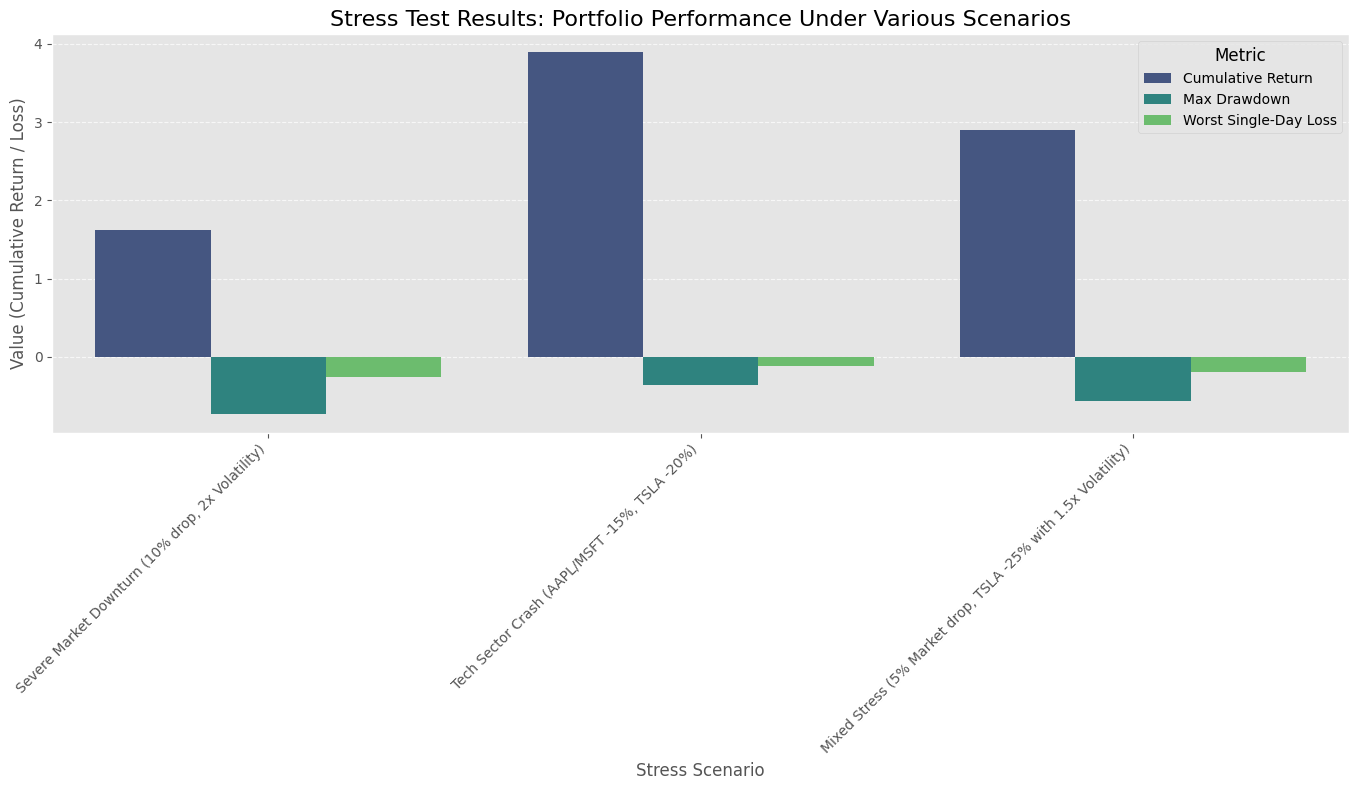

Stress test results visualized.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print('### Visualizing Stress Test Results')

# Prepare data for plotting
plot_data = []
for scenario_name, metrics in scenario_results.items():
    plot_data.append({
        'Scenario': scenario_name,
        'Metric': 'Cumulative Return',
        'Value': metrics['Cumulative Return']
    })
    plot_data.append({
        'Scenario': scenario_name,
        'Metric': 'Max Drawdown',
        'Value': metrics['Max Drawdown']
    })
    plot_data.append({
        'Scenario': scenario_name,
        'Metric': 'Worst Single-Day Loss',
        'Value': metrics['Worst Single-Day Loss']
    })

plot_df = pd.DataFrame(plot_data)

# Create the visualization
plt.figure(figsize=(14, 8))
sns.barplot(x='Scenario', y='Value', hue='Metric', data=plot_df, palette='viridis')

plt.title('Stress Test Results: Portfolio Performance Under Various Scenarios', fontsize=16)
plt.xlabel('Stress Scenario', fontsize=12)
plt.ylabel('Value (Cumulative Return / Loss)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10) # Rotate labels for better readability
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metric', fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.show()

print("Stress test results visualized.")

## Overall Project Analysis

This project provided a comprehensive framework for portfolio optimization, from initial data collection to advanced risk management techniques. Here's an overall analysis:

**Project Goal & Problem Formulation:**

The primary objective was to construct an optimal portfolio by maximizing the Sharpe Ratio, subject to constraints like being fully invested and long-only. This involved balancing expected portfolio returns against its volatility, with a consideration for a risk-free rate.

**Methodologies Applied:**

1.  **Data Collection & Preprocessing**: Historical stock data for a selected portfolio (AAPL, MSFT, GOOGL, TSLA) was fetched from Yahoo Finance, and then processed to derive daily returns.
2.  **Portfolio Optimization**: The core optimization aimed to find asset weights that maximized the Sharpe Ratio. This was extended to:
    *   **Efficient Frontier**: Visualizing the range of optimal portfolios offering the highest return for a given risk level.
    *   **Minimum Volatility Portfolio**: Identifying the portfolio with the lowest possible risk.
3.  **Risk Analysis (VaR)**:
    *   **Historical VaR**: Calculated by analyzing the empirical distribution of past portfolio returns.
    *   **Parametric VaR**: Calculated assuming a normal distribution of returns, using mean and standard deviation.
    *   **Comparison**: Revealed discrepancies, particularly at higher confidence levels, suggesting non-normal (fat-tailed) distribution of returns.
4.  **Backtesting with Rolling Optimization**: A robust backtesting framework was implemented, using a rolling window approach to simulate periodic re-optimization. This evaluates the strategy's performance on out-of-sample data, mimicking real-world investment.
5.  **Factor Model Integration**: Rolling betas were calculated for each asset against the S&P 500 to understand their dynamic sensitivity to market movements over time.
6.  **Stress Testing & Scenario Analysis**: Various adverse market conditions (e.g., severe market downturn, tech sector crash, mixed stress) were defined and simulated to assess the portfolio's resilience and potential downside risks under extreme events.


**Key Findings & Insights:**

*   **Optimal Allocation**: The initial optimization highlighted that not all assets contribute equally to maximizing the Sharpe Ratio, with GOOGL receiving a minimum allocation due to its risk-return profile relative to others.
*   **Efficient Frontier**: Provided a visual representation of the trade-off between risk and return, pinpointing the maximum Sharpe Ratio and minimum volatility portfolios.
*   **VaR Insights**: The comparison of Historical vs. Parametric VaR underscored the importance of considering non-normal return distributions, as Historical VaR often indicated higher potential losses in extreme scenarios, especially at 99% confidence.
*   **Backtesting Performance**: The rolling-optimized portfolio generally outperformed a naive equally-weighted benchmark in terms of annualized return and maximum drawdown, validating the benefits of active optimization and periodic rebalancing.
*   **Dynamic Betas**: Rolling betas demonstrated how asset sensitivities to the market can change over time, offering valuable context for risk management and tactical allocation.
*   **Stress Test Vulnerabilities**: Stress testing revealed critical vulnerabilities:
    *   The portfolio was highly susceptible to systemic market downturns (73% max drawdown in one scenario).
    *   High-beta, volatile assets like TSLA could disproportionately amplify drawdowns when combined with market stress.
    *   The project successfully demonstrated that 'risk' is multi-dimensional and scenario-dependent.

**Overall Conclusion:**

This project successfully developed a comprehensive portfolio optimization tool, integrating modern portfolio theory concepts with practical considerations like backtesting, dynamic risk metrics, and stress testing. It not only identifies an 'optimal' portfolio under normal conditions but critically evaluates its resilience under adverse scenarios, providing a more realistic and actionable understanding of investment risk. The insights gained emphasize the importance of continuous monitoring, adaptive strategies, and robust risk management beyond just maximizing returns, especially for managing potential large drawdowns during market crises.


## Hedging Strategies

The analysis so far clearly highlighted the vulnerabilities of our optimal portfolio to various market stresses, with significant potential drawdowns in severe scenarios. This underscores the critical need for **hedging strategies** in portfolio management.

### What is Hedging?

**Hedging** is a risk management strategy employed to offset losses in investments by taking an opposite position in a related asset. Essentially, it's like buying an insurance policy for your portfolio. The primary goal of hedging is not to generate profit, but to reduce risk and protect against adverse price movements in an asset or portfolio.


By strategically implementing hedging techniques, investors can protect their portfolios from these various risks, enhancing their long-term financial security and achieving their investment objectives with greater confidence.

## Hedging in portfolio management

Hedging in portfolio management is a strategy used to offset potential losses from adverse price movements of assets. It typically involves taking an opposite position in a related security.

### Why is Hedging Important?

Hedging is crucial for several reasons:

1.  **Risk Mitigation**: It helps to protect a portfolio from unforeseen market fluctuations and specific risks.
2.  **Capital Preservation**: By limiting downside risk, hedging strategies aim to preserve the capital invested.
3.  **Portfolio Stability**: It can reduce volatility, making portfolio returns more predictable.
4.  **Flexibility**: Hedging allows investors to maintain existing positions while guarding against short-term risks without having to sell off assets.
5.  **Diversification Enhancement**: While diversification spreads risk, hedging actively counteracts specific risks that diversification alone might not fully address.

### Types of Risks Hedging Can Mitigate:

Hedging strategies can be employed to mitigate various types of financial risks, including:

*   **Market Risk**: Protection against broad market downturns.
*   **Interest Rate Risk**: Guarding against losses due to unfavorable changes in interest rates, particularly for bond portfolios.
*   **Currency Risk**: For international investments, hedging protects against adverse movements in exchange rates.
*   **Commodity Price Risk**: Important for portfolios with exposure to raw materials.
*   **Inflation Risk**: Protecting the purchasing power of returns against rising inflation.

## Diversification and Asset Allocation

We now discuss diversification across different asset classes, geographies, and sectors as a foundational hedging strategy, and how proper asset allocation can inherently reduce risk.

### Diversification as a Foundational Hedging Strategy

Diversification is a core principle in finance that involves spreading investments across various financial instruments, industries, and other categories to minimize exposure to any single asset or risk. As a foundational hedging strategy, diversification aims to reduce unsystematic risk (specific risk) inherent in individual assets, without necessarily sacrificing expected returns.

*   **Across Different Asset Classes**: Investing in a mix of asset classes (e.g., stocks, bonds, real estate, commodities) helps hedge against market-specific downturns. For instance, bonds often perform well when stocks decline, providing a cushion for the overall portfolio. This helps smooth out portfolio returns and reduces overall volatility.

*   **Across Geographies**: Spreading investments across different countries or regions can hedge against country-specific economic downturns, political instability, or regulatory changes. A decline in one regional market may be offset by growth in another, mitigating the impact on the total portfolio.

*   **Across Sectors**: Within equities, diversifying across various economic sectors (e.g., technology, healthcare, financials, consumer staples) helps hedge against sector-specific challenges. For example, a downturn in the tech sector might be balanced by stability or growth in utilities, reducing the overall portfolio's exposure to industry-specific shocks.

### Asset Allocation for Inherent Risk Reduction

**Asset allocation** is the process of dividing an investment portfolio among different asset categories, such as stocks, bonds, and cash. The objective is to balance risk and reward by adjusting the percentage of each asset in relation to the investor's goals, risk tolerance, and investment horizon. Proper asset allocation inherently reduces risk in several ways:

1.  **Risk-Return Optimization**: Different asset classes have varying risk-return profiles and tend to react differently to market conditions. By strategically allocating across these classes, investors can achieve a desired level of expected return for a given level of risk, or minimize risk for a target return.

2.  **Correlation Benefits**: Assets typically do not move in perfect lockstep. When one asset class is underperforming, another might be performing well. For example, during periods of high inflation, commodities might offer a hedge against declining stock and bond values. The lower the correlation between assets, the greater the diversification benefit.

3.  **Long-term Stability**: A well-diversified portfolio, achieved through thoughtful asset allocation, tends to exhibit more stable returns over the long term, reducing the likelihood of catastrophic losses that might be associated with concentrated bets. This provides a more robust foundation for weathering market volatility.

In essence, both diversification and asset allocation serve as proactive hedging mechanisms, not by taking explicit derivative positions, but by structuring the portfolio in a way that its various components offset each other's risks, leading to a more resilient and stable investment outcome.

## Using Options Contracts for Hedging

### Options Contracts: Puts and Calls
Options contracts are financial derivatives that give the buyer the right, but not the obligation, to buy or sell an underlying asset at a specified price (the strike price) on or before a certain date (the expiration date). There are two main types:

*   **Call Option:** Grants the holder the right to *buy* an underlying asset at the strike price. Buyers of calls anticipate the asset's price to rise.
*   **Put Option:** Grants the holder the right to *sell* an underlying asset at the strike price. Buyers of puts anticipate the asset's price to fall.

### Hedging with Protective Puts
**Protective puts** are a strategy used to limit the downside risk of an existing stock or portfolio position. It involves buying a put option on an asset you already own.

**How it works:**
*   You own shares of a stock (or a portfolio of stocks).
*   You buy a put option for the same number of shares (or a relevant index ETF for a portfolio) with a strike price close to the current market price.

**Benefits:**
*   **Downside Protection:** The put option acts like an insurance policy, setting a floor on potential losses. If the stock price falls below the strike price, you can exercise the put to sell your shares at the higher strike price, limiting your loss.
*   **Retain Upside Potential:** You still benefit from any increase in the stock's price, as the put option only becomes valuable if the price falls.

**Drawbacks:**
*   **Cost:** The primary drawback is the premium paid for the put option, which reduces your overall returns if the stock price remains stable or goes up.
*   **Limited Profit:** If the stock price rises significantly, the premium paid for the put will eat into profits.
*   **Expiration:** Puts have expiration dates, so the protection is temporary.

### Hedging with Covered Calls
**Covered calls** are a strategy primarily used to generate income from an existing stock position while providing some limited downside protection. It involves owning shares of a stock and selling (writing) call options against those shares.

**How it works:**
*   You own shares of a stock.
*   You sell a call option for the same number of shares with a strike price above the current market price.
*   The premium received for selling the call generates immediate income.

**Benefits:**
*   **Income Generation:** You receive the option premium upfront, which can enhance returns in stable or moderately rising markets.
*   **Partial Downside Protection:** The premium received acts as a buffer against minor price declines. Your break-even point is reduced by the amount of the premium.

**Drawbacks:**
*   **Limited Upside Potential:** If the stock price rises significantly above the strike price, your shares will likely be "called away" (exercised) at the strike price, meaning you miss out on further gains above that level.
*   **Unlimited Downside Risk (relative to premium):** While the premium offers some protection, if the stock price drops substantially, you still incur losses on your stock holdings beyond the premium received. The strategy does not protect against significant market crashes.
*   **Opportunity Cost:** If the stock experiences a strong rally, the limited upside can be a significant opportunity cost.

## Using Futures Contracts for Hedging

 Aim is to use futures contracts to hedge against price fluctuations in underlying assets or market indices, allowing investors to lock in prices for future transactions or offset market movements.

### Futures Contracts for Hedging

**1. Definition and Primary Purpose:**

A **futures contract** is a standardized legal agreement to buy or sell a specific commodity, asset, or financial instrument at a predetermined price at a specified time in the future. The primary purpose of futures contracts is to provide price discovery and risk transfer mechanisms. For hedging, their main role is to **mitigate price fluctuation risk** for producers, consumers, or investors. By entering into a futures contract, parties can "lock in" a future price for an asset, protecting themselves from adverse price movements.

**2. How Futures Contracts are Used for Hedging:**

Futures contracts allow participants to offset potential losses from price changes in a spot (cash) market by taking an opposite position in the futures market.

*   **Hedging Specific Assets (e.g., Commodities):**
    *   **Producers (Short Hedge):** A farmer expecting to harvest corn in three months can sell corn futures contracts today. This locks in a selling price for their future harvest. If the spot price of corn falls by harvest time, the loss in the physical market is offset by a gain in their short futures position (they can buy back the futures contract at a lower price). If the spot price rises, they gain in the physical market but lose on the futures contract, effectively selling their crop at the price they locked in.
    *   **Consumers (Long Hedge):** A bread manufacturer needs wheat in six months. They can buy wheat futures contracts today. This locks in a purchase price. If the spot price of wheat rises, the increased cost of buying physical wheat is offset by a gain in their long futures position (they can sell the futures contract at a higher price). If the spot price falls, they save on physical wheat but lose on the futures contract.

*   **Hedging Market Indices (e.g., S&P 500 Futures):**
    *   **Portfolio Managers:** An equity portfolio manager holding a diversified portfolio that closely tracks the S&P 500 index might be concerned about a short-term market downturn. Instead of selling off all their individual stocks (which can incur transaction costs and taxes), they can sell S&P 500 futures contracts. If the market falls, the loss in their physical stock portfolio is offset by a gain in their short S&P 500 futures position. This is a quick and efficient way to hedge systemic market risk without disrupting the underlying portfolio.
    *   **Expected Investments:** Conversely, if a fund manager anticipates a large inflow of cash in the future that they want to invest in the S&P 500, but fears a market rally before they can deploy the cash, they can buy S&P 500 futures. This locks in a purchase price for their future market exposure.

**3. Benefits of Using Futures for Hedging:**

*   **Cost-Effectiveness:** Futures contracts typically involve lower transaction costs compared to buying or selling the underlying physical assets. This is especially true for large-scale hedging.
*   **High Liquidity:** Futures markets, particularly for major commodities and indices, are highly liquid, allowing hedgers to easily enter and exit positions without significantly impacting prices.
*   **Leverage:** Futures require only a small percentage of the contract's value as initial margin, providing significant leverage. While this can magnify gains, it's primarily used in hedging to achieve exposure efficiently.
*   **Ability to Manage Both Long and Short Positions:** Futures allow investors to easily take both long (buy) and short (sell) positions, making them versatile for hedging against both price increases and decreases.
*   **Price Discovery:** The transparent nature of futures markets helps in discovering future prices, which is valuable for business planning.

**4. Drawbacks and Risks Associated with Futures Hedging:**

*   **Margin Requirements:** Despite the leverage, futures contracts require initial and maintenance margin. If the market moves against the hedger's position, they may face margin calls, requiring additional capital. Failure to meet a margin call can lead to forced liquidation of positions.
*   **Basis Risk:** This is the risk that the relationship between the spot price of the underlying asset and the futures price changes unexpectedly. A perfect hedge would see spot and futures prices move in lockstep, but in reality, their convergence at expiration might not be perfect, or their relationship over the hedging period might shift. This imperfect correlation can lead to hedging losses.
*   **Magnified Losses:** While leverage can be beneficial, it also means that adverse price movements can lead to significant losses that exceed the initial margin, requiring more capital than initially invested.
*   **Opportunity Cost:** A perfect hedge eliminates downside risk, but also limits upside potential. If prices move favorably, the hedged position will underperform an unhedged position, representing an opportunity cost.
*   **Liquidity Risk:** While generally liquid, certain less active futures markets can suffer from liquidity issues, making it difficult to enter or exit positions at desired prices.
*   **Complexity:** Understanding and managing futures contracts requires specialized knowledge and constant monitoring.

## Using Inverse ETFs/Funds

Inverse Exchange Traded Funds (ETFs) or mutual funds can be used to gain inverse exposure to an index or sector, effectively hedging against a market downturn without using complex derivatives.

### What are Inverse ETFs/Funds?
Inverse Exchange Traded Funds (ETFs) and mutual funds are investment vehicles designed to deliver returns that are inversely correlated to the performance of a specific index, sector, commodity, or currency. This means if the underlying benchmark declines by 1%, an inverse ETF aims to increase in value by approximately 1% (before fees and expenses). Some inverse ETFs are also "leveraged," meaning they seek to deliver a multiple of the inverse performance (e.g., a 2x inverse ETF would aim for a 2% gain if the benchmark drops 1%).

### How They Provide Inverse Exposure
Unlike traditional ETFs or mutual funds that hold the underlying assets or track them directly, inverse ETFs achieve their objective through a combination of financial instruments such as:

*   **Short Selling**: Borrowing securities and selling them, with the expectation of buying them back at a lower price to return to the lender.
*   **Derivatives**: Using futures contracts, options, or swap agreements to take a short position on the underlying index or assets.

The fund managers actively manage these positions to maintain the inverse correlation. It's crucial to understand that these funds are typically reset daily, meaning they aim to provide the inverse of the *daily* performance. Over longer periods, compounding effects can lead to significant deviations from the expected inverse return of the underlying index.

### Inverse ETFs/Funds as a Hedging Tool
Inverse ETFs/funds offer a straightforward way for investors to hedge their portfolios against market downturns, particularly without engaging in complex derivatives or short selling individual stocks.

*   **Hedging Mechanism**: If an investor holds a portfolio of stocks that largely mirrors a market index (e.g., S&P 500), they can purchase an inverse S&P 500 ETF. If the market falls, the gains from the inverse ETF can offset some or all of the losses in their long portfolio. This provides a temporary shield against negative market movements.

*   **Contrast with Derivatives**: While derivatives (like put options or futures contracts) can also be used for hedging, they often require more advanced knowledge, active management, and can involve significant risks related to expiration dates, strike prices, and margin calls. Inverse ETFs, in contrast, offer a simpler, single-ticker solution that can be bought and sold like regular stocks, making them more accessible to retail investors.

### Key Benefits

1.  **Simplicity**: Easy to understand and trade, often requiring just a standard brokerage account.
2.  **Accessibility**: Provides exposure to short strategies without needing to open a margin account or understand complex short-selling mechanics.
3.  **Diversification of Hedging**: Can hedge against broad market, sector, or even commodity downturns with a single investment.
4.  **No Margin Calls (typically)**: Unlike direct short selling or certain derivatives, inverse ETFs do not typically expose investors to margin calls, reducing a layer of complexity and risk.

### Potential Drawbacks and Risks

1.  **Daily Reset and Compounding**: This is the most significant risk. Due to daily rebalancing, the returns of inverse ETFs over periods longer than one day can deviate substantially from the simple inverse of the underlying index's performance. This effect is magnified by volatility, making them unsuitable for long-term holding.
2.  **High Expense Ratios**: Inverse ETFs often have higher management fees compared to traditional index funds, which can erode returns.
3.  **Tracking Error**: The fund's performance might not perfectly mirror the inverse of the benchmark's performance due to trading costs, rebalancing issues, and other operational factors.
4.  **Leverage Risk (for leveraged ETFs)**: Leveraged inverse ETFs amplify both gains and losses. While they can provide outsized returns in a sharp downturn, they can also lead to rapid losses if the market moves against the inverse position, or even if the market moves sideways due to volatility decay.
5.  **Not Suitable for "Buy and Hold"**: Due to their daily rebalancing and compounding effects, inverse ETFs are generally considered tactical tools for short-term hedging or speculation, not long-term investments.

## Currency Hedging in International Portfolios

If applicable to international portfolios, various strategies can be used to hedge against adverse currency exchange rate movements.

### 1. What is Currency Hedging?
Currency hedging is a financial strategy employed by investors to mitigate the risk of adverse currency exchange rate movements when investing in assets denominated in foreign currencies. In essence, it involves taking a financial position that offsets potential losses (or gains) from fluctuations in currency exchange rates. The primary purpose is to "lock in" an exchange rate for a future transaction or a portfolio's value, thereby reducing uncertainty and protecting the investor's domestic currency value of their foreign investments.

### 2. Why is it important?
For international portfolios, currency hedging is crucial because fluctuations in exchange rates can significantly impact the overall returns of foreign investments. An investor might see strong returns in local currency terms from a foreign asset, but if the foreign currency depreciates against their home currency, those gains could be eroded or even turn into losses when converted back. Currency hedging helps to:
*   **Reduce Volatility**: Stabilizes the domestic currency value of foreign assets.
*   **Protect Returns**: Safeguards the investment's returns from unfavorable currency movements.
*   **Improve Planning**: Provides more predictable cash flows and portfolio values for investors and corporations.
*   **Isolate Asset Performance**: Allows investors to focus more on the underlying performance of the foreign asset rather than extraneous currency risk.

### 3. Common Strategies or Instruments for Currency Hedging
Investors can use various financial instruments to hedge currency risk:

*   **Forward Contracts**: A customizable agreement between two parties to exchange a specified amount of one currency for another at a predetermined exchange rate on a future date. They are typically over-the-counter (OTC) and are highly flexible.

*   **Futures Contracts**: Similar to forwards, but they are standardized, exchange-traded contracts to buy or sell a specified amount of foreign currency at a specified price on a future date. They are more liquid but less customizable than forwards.

*   **Options Contracts**: Give the holder the right, but not the obligation, to buy (call option) or sell (put option) a currency at a specified exchange rate (strike price) on or before a specified date. Options provide flexibility but require paying a premium.

*   **Currency Exchange-Traded Funds (ETFs) / Exchange-Traded Notes (ETNs)**: These are publicly traded investment funds that track the performance of a currency pair or basket of currencies. Some are specifically designed to offer hedged exposure to foreign markets, meaning they invest in foreign assets but simultaneously hedge out the currency risk.

### 4. Benefits of Currency Hedging
*   **Risk Reduction**: Significantly reduces the exposure of a portfolio's value to adverse currency fluctuations.
*   **Stabilized Returns**: Helps in maintaining more consistent returns in the investor's home currency.
*   **Improved Diversification**: Allows investors to gain pure exposure to foreign asset markets, harnessing their diversification benefits without the added layer of currency risk.
*   **Capital Preservation**: Protects capital from significant erosion due to unexpected currency depreciation.

### 5. Drawbacks or Considerations
*   **Cost**: Hedging is not free. There are transaction costs, bid-ask spreads, and potentially premiums (for options) or interest rate differentials (for forwards/futures) that can eat into returns.
*   **Limited Upside**: While hedging protects against downside currency movements, it also foregoes potential gains if the foreign currency strengthens against the home currency. It essentially caps both the downside and upside of currency movements.
*   **Imperfect Hedge**: It is difficult to achieve a perfect hedge, especially for ongoing portfolios with dynamic values. Mismatches in hedging instruments, timing, or amounts can lead to basis risk.
*   **Complexity**: Implementing and managing hedging strategies can be complex, requiring expertise and continuous monitoring.
*   **Counterparty Risk**: For OTC instruments like forward contracts, there is a risk that the counterparty may default on their obligations.

## Hedging Strategies Summary:


*   **Introduction to Hedging Concepts**: The analysis began by defining hedging as a risk management strategy to offset potential investment losses, emphasizing its importance for risk mitigation, capital preservation, portfolio stability, flexibility, and diversification enhancement. It identified key risks hedging can mitigate, including market, interest rate, currency, commodity price, and inflation risk.
*   **Diversification and Asset Allocation**: Diversification was explained as a foundational hedging strategy, reducing unsystematic risk by spreading investments across asset classes, geographies, and sectors. Asset allocation was highlighted for inherently reducing risk through risk-return optimization, leveraging correlation benefits between assets, and promoting long-term portfolio stability.
*   **Options Contracts for Hedging**: The summary detailed the use of options (puts and calls) for hedging.
    *   **Protective Puts**: Described as an insurance policy for existing assets, limiting downside risk while retaining upside potential, but incurring a premium cost and having temporary protection.
    *   **Covered Calls**: Explained as a strategy to generate income from existing holdings, offering partial downside protection from the premium received, but capping upside potential if the stock price rises significantly.
*   **Futures Contracts for Hedging**: Futures contracts were presented as tools to hedge against price fluctuations by locking in future prices.
    *   They enable both long (for anticipated purchases) and short (for anticipated sales) hedges for specific assets (e.g., commodities) and market indices (e.g., S&P 500 futures).
    *   Benefits include cost-effectiveness, high liquidity, and leverage, while drawbacks involve margin requirements, basis risk, magnified losses, and opportunity cost.
*   **Currency Hedging**: For international portfolios, currency hedging was introduced to mitigate adverse exchange rate movements.
    *   It reduces volatility and protects returns by locking in exchange rates.
    *   Common instruments include forward contracts, futures contracts, options contracts, and currency ETFs/ETNs.
    *   While offering risk reduction and stabilized returns, currency hedging incurs costs, limits upside gains, can be complex, and introduces basis and counterparty risks.

### Insights

*   The choice of hedging strategy is highly dependent on the specific risk an investor aims to mitigate, their investment objectives, and their risk tolerance. For instance, diversification and asset allocation are foundational for inherent risk reduction, while derivatives (options, futures) offer targeted protection but introduce complexity and costs.
*   Further analysis should delve into quantitative methods for evaluating the effectiveness and cost-benefit of different hedging strategies within the context of the identified portfolio vulnerabilities, considering factors like hedge ratio optimization and the impact of hedging costs on overall portfolio returns.
